# SETUP

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm

import lightgbm as lgb
import matplotlib.pyplot as plt

C:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load dataset

```
['time', 'solar1', 'solar2', 'real_time_power', 'day_power', 'month', 'day', 'hour', 'minute', 
'temperature_3H', 'sky', 'rainfall_probability', 'rainfall', 'snow', 'humidity', 'wind_speed', 'wind_direction', 'Elevation_angle', 'Azimuth_angle', 'dust_132']
```

In [27]:
data_A_raw = pd.read_pickle('C:/Users/ewpadmin/JIHYUN/aaa.pkl')
data_B_raw = pd.read_pickle('C:/Users/ewpadmin/JIHYUN/bbb.pkl')
data_C_raw = pd.read_pickle('C:/Users/ewpadmin/JIHYUN/ccc.pkl')

In [28]:
def make_dirty(data):
    dirty = []
    capacity = 5
    for rain in data.rainfall:
        capacity -= rain

        if capacity < 0:
            dirty.append(0)
            capacity = 5
        else:
            dirty.append(capacity)

    data['dirty'] = dirty
    data.dirty = data.dirty.apply(lambda x : round(x, 1))
    
    return data

In [29]:
def make_dirty_v2(data):
    data['dirty_v2'] = data.humidity.apply(lambda x : np.exp(x / 5)) * data.dust_132.apply(lambda x : np.exp(x / 5))
    
    return data

In [30]:
# data_A_raw = make_dirty(data_A_raw)
# data_B_raw = make_dirty(data_B_raw)
# data_C_raw = make_dirty(data_C_raw)

data_A_raw = make_dirty_v2(data_A_raw)
data_B_raw = make_dirty_v2(data_B_raw)
data_C_raw = make_dirty_v2(data_C_raw)

# Function

In [6]:
def mape_zeroless(act, pred):
    
    mape = pd.DataFrame({'act':act.reshape(-1,).round(2), 'pred':pred.reshape(-1,).round(2)})
    mape['error'] = np.abs((mape.act-mape.pred) /mape.act)
    
    zero_idx = mape[mape.act == 0].index
    mape.drop(zero_idx, axis=0, inplace=True)

    result = 100 - np.mean(mape.error) * 100
    return result

In [44]:
# preprocessing II : make X, y // train, text // scaling
def model_power(data_raw, model='rf', target='real_time_power', test=False):
    
    # index
    index = data_raw[['time']]
    index = index.iloc[-5181:, :]
    
    # make train
    if target == 'real_time_power':
        y = data_raw[['real_time_power']]
        X = data_raw.drop(['time', 'solar1', 'solar2', 'real_time_power', 'day_power'], axis=1)
    elif target == 'day_power':
        y = data_raw[['day_power']]
        X = data_raw.drop(['time', 'solar1', 'solar2', 'real_time_power', 'day_power'], axis=1)        
    elif target == 'solar1':
        y = data_raw[['solar1']]
        X = data_raw.drop(['time', 'solar1', 'solar2', 'real_time_power', 'day_power'], axis=1)
    elif target == 'solar2':
        y = data_raw[['solar2']]
        X = data_raw.drop(['time', 'solar1', 'solar2', 'real_time_power', 'day_power'], axis=1)
    else:
        print("No target.")
        
    
    # scaling
    X_mms = MinMaxScaler()
    y_mms = MinMaxScaler()
    
    X_sc = X_mms.fit_transform(X)
    y_sc = y_mms.fit_transform(y)
    
    if test == False:
        
        # train / test
        X_train = X_sc[:-5181, :]
        X_test = X_sc[-5181:, :]
        y_train = y_sc[:-5181, :]
        y_test = y_sc[-5181:]

        # modeling
        if model == 'rf':
            rf = RandomForestRegressor(n_estimators=25, criterion='mse', max_features=10, max_depth=25, 
                                         min_samples_leaf=2, min_samples_split=3, verbose=0, n_jobs=4)
            model = rf.fit(X_train, y_train)
        elif model == 'lgb':
            lgb_ = lgb.LGBMRegressor(learning_rate=0.04, max_depth=-1, n_estimators=118, num_leaves=41, n_jobs=4)
            model = lgb_.fit(X_train, y_train)
        elif model == 'NN':
            input_dim = X_train.shape[1]
            model = Sequential()
            model.add(Dense(64, input_dim=input_dim, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(1))

            model.compile(optimizer='rmsprop', loss='mse')
            hist = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0, validation_data=(X_test, y_test))  
        else:
            print("No model.")

        # validation
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mape = mape_zeroless(y_test, y_pred)
        grade = 100 - mape
        print("rmse : %.4f | r2 : %.4f | grade : %.4f" % (rmse, r2, grade))
        print("-" * 50)

        y_test = y_mms.inverse_transform(y_test)
        y_pred = y_mms.inverse_transform(y_pred.reshape(-1, 1))
        return y_pred, y_test, index, rf, X.columns
    
    else:
        # X_test = pd.read_pickle('C:/Users/ewpadmin/KMS/forecast_2nd.pkl')
        X_test = pd.read_pickle('C:/Users/ewpadmin/KMS/forecast_2nd_quad.pkl')
        
        index = X_test.time
        
        X_test.drop('time', axis=1, inplace=True)
        X_test = X_mms.transform(X_test)
        
        X_train = X_sc
        y_train = y_sc
        
        # modeling
        if model == 'rf':
            rf = RandomForestRegressor(n_estimators=25, criterion='mse', max_features=10, max_depth=25, 
                                         min_samples_leaf=2, min_samples_split=3, verbose=0, n_jobs=4)
            model = rf.fit(X_train, y_train)
        elif model == 'lgb':
            lgb_ = lgb.LGBMRegressor(learning_rate=0.04, max_depth=-1, n_estimators=118, num_leaves=41, n_jobs=4)
            model = lgb_.fit(X_train, y_train)
        elif model == 'NN':
            input_dim = X_train.shape[1]
            model = Sequential()
            model.add(Dense(64, input_dim=input_dim, activation='relu'))
            model.add(Dense(64, activation='relu'))
            model.add(Dense(1))

            model.compile(optimizer='rmsprop', loss='mse')
            hist = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0, validation_data=(X_test, y_test))  
        else:
            print("No model.")
            
        # validation
        y_pred = model.predict(X_test)
        print("-" * 50)

        y_pred = y_mms.inverse_transform(y_pred.reshape(-1, 1))
        return y_pred, [], index, rf

```
['time', 'solar1', 'solar2', 'real_time_power', 'day_power', 'month', 'day', 'hour', 'minute', 
'temperature_3H', 'sky', 'rainfall_probability', 'rainfall', 'snow', 'humidity', 'wind_speed', 'wind_direction', 'Elevation_angle', 'Azimuth_angle', 'dust_132']
```

In [54]:
# modeling
def tester(model='rf', target='A_Site', columns_drop=[], days=7, test=False):

    y_pred_A, y_test_A, index_A, rf_A, columns_A = model_power(data_A_raw, model=model, test=test)
    y_pred_B, y_test_B, index_B, rf_B, columns_B = model_power(data_B_raw, model=model, test=test)
    y_pred_C, y_test_C, index_C, rf_C, columns_C = model_power(data_C_raw, model=model, test=test)
    
    data_result = pd.DataFrame(columns=['feature', 'importance'])
    data_result['feature'] = columns_A
    data_result['importance'] = rf_A.feature_importances_
    display(data_result.sort_values(by='importance', ascending=False))
    
    data_result = pd.DataFrame(columns=['feature', 'importance'])
    data_result['feature'] = columns_B
    data_result['importance'] = rf_B.feature_importances_
    display(data_result.sort_values(by='importance', ascending=False))
    
    data_result = pd.DataFrame(columns=['feature', 'importance'])
    data_result['feature'] = columns_C
    data_result['importance'] = rf_C.feature_importances_
    display(data_result.sort_values(by='importance', ascending=False))

    # pred
    data_pred_concat = pd.DataFrame(columns=['A_Site', 'B_Site', 'C_Site'])
    data_pred_concat['A_Site'] = y_pred_A.reshape(y_pred_A.shape[0],)
    data_pred_concat['B_Site'] = y_pred_B.reshape(y_pred_B.shape[0],)
    data_pred_concat['C_Site'] = y_pred_C.reshape(y_pred_C.shape[0],)
    data_pred_concat.index = index_A.values.reshape(index_A.shape[0],)

    # act
    if test == False:
        data_act_concat = pd.DataFrame(columns=['A_Site', 'B_Site', 'C_Site'])
        data_act_concat['A_Site'] = y_test_A.reshape(y_test_A.shape[0],)
        data_act_concat['B_Site'] = y_test_B.reshape(y_test_B.shape[0],)
        data_act_concat['C_Site'] = y_test_C.reshape(y_test_C.shape[0],)
        data_act_concat.index = index_A.values.reshape(index_A.shape[0],)

        n = 0
        m = days
        r = round(54 / m)
        for n in [24*4*m*i for i in range(r)]:
            plt.figure(figsize=(15, 5))
            data_pred_concat.iloc[n:n+24*4*m][target].plot()
            data_act_concat.iloc[n:n+24*4*m][target].plot()
            plt.show()   
    else:
        plt.figure(figsize=(15, 5))
        data_pred_concat['A_Site'].plot()
        data_pred_concat['B_Site'].plot()
        data_pred_concat['C_Site'].plot()
        plt.show()

### 2nd submission testing

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.1075 | r2 : 0.8130 | grade : 94.7713
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0879 | r2 : 0.8084 | grade : 113.6738
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0635 | r2 : 0.8583 | grade : 90.0281
--------------------------------------------------


feature  importance
12       Elevation_angle    0.547405
2                   hour    0.120360
5                    sky    0.072649
6   rainfall_probability    0.065328
13         Azimuth_angle    0.064891
4         temperature_3H    0.023203
9               humidity    0.022416
10            wind_speed    0.021868
14              dust_132    0.021164
1                    day    0.018689
11        wind_direction    0.009406
0                  month    0.007123
3                 minute    0.003053
7               rainfall    0.002283
8                   snow    0.000162
15              dirty_v2    0.000000

feature  importance
12       Elevation_angle    0.625430
2                   hour    0.116656
5                    sky    0.052593
6   rainfall_probability    0.042312
13         Azimuth_angle    0.041137
4         temperature_3H    0.024624
9               humidity    0.021251
10            wind_speed    0.020737
14              dust_132    0.018456
1                    day    0.014815
0                  month    0.010063
11        wind_direction    0.007854
3                 minute    0.002893
7               rainfall    0.001151
8                   snow    0.000028
15              dirty_v2    0.000000

feature  importance
12       Elevation_angle    0.580457
2                   hour    0.102581
13         Azimuth_angle    0.085308
5                    sky    0.056512
6   rainfall_probability    0.045022
4         temperature_3H    0.029422
10            wind_speed    0.022667
14              dust_132    0.021158
9               humidity    0.018951
1                    day    0.018054
0                  month    0.007881
11        wind_direction    0.007865
3                 minute    0.002974
7               rainfall    0.001070
8                   snow    0.000078
15              dirty_v2    0.000000

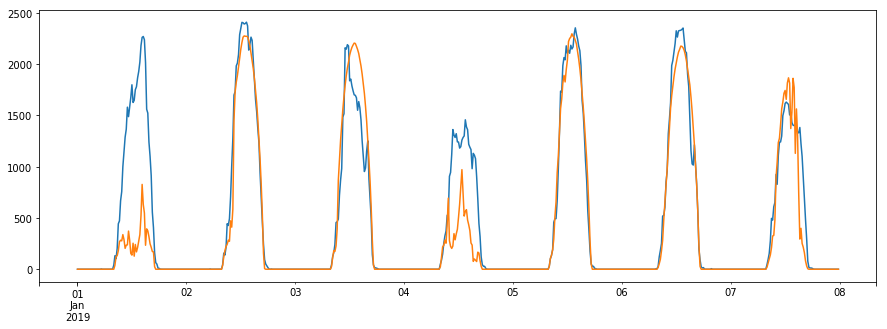

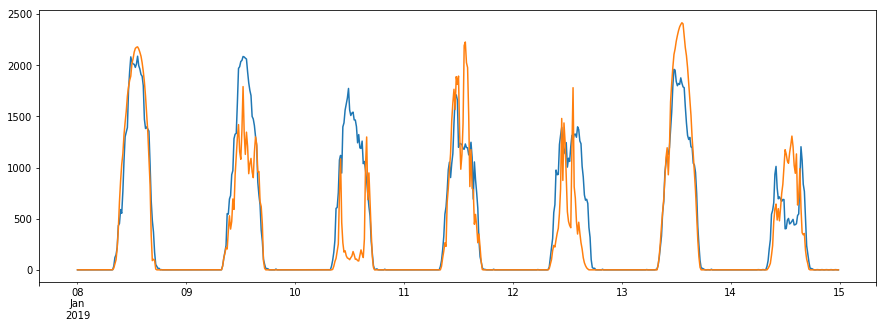

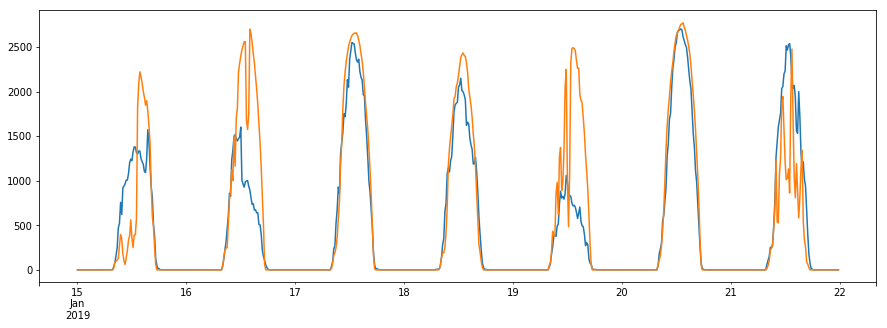

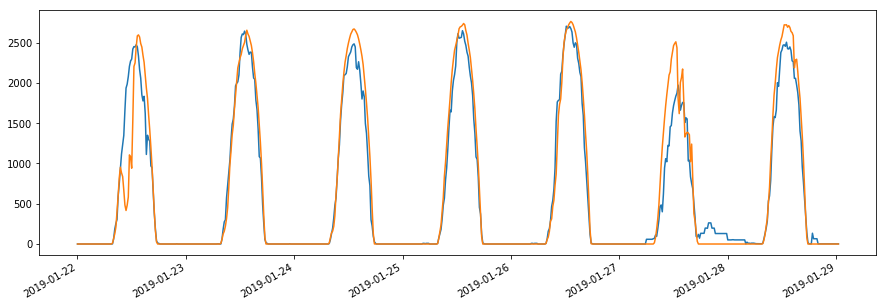

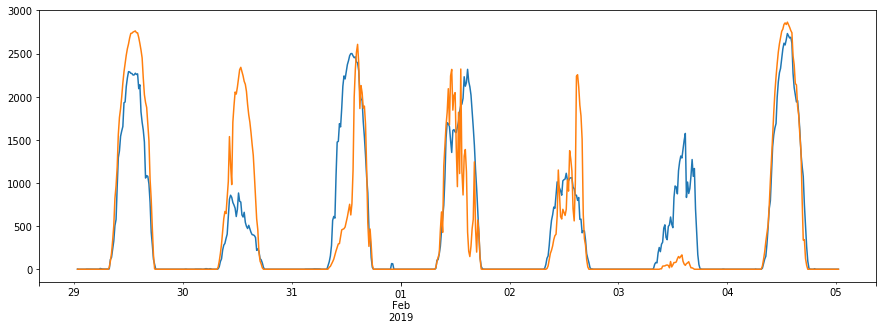

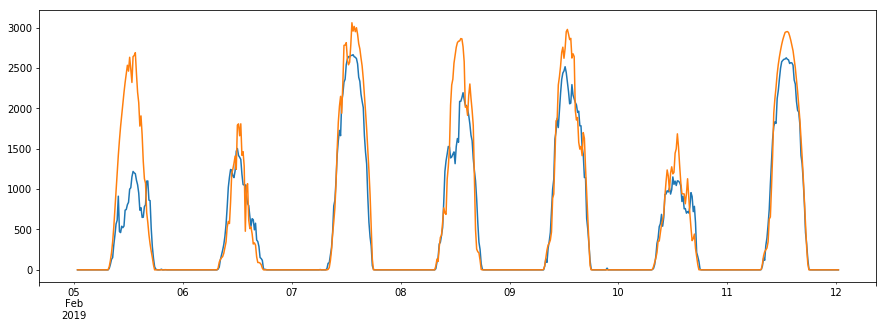

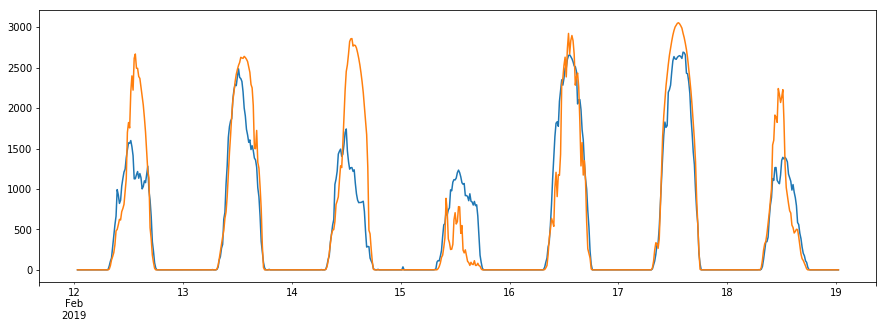

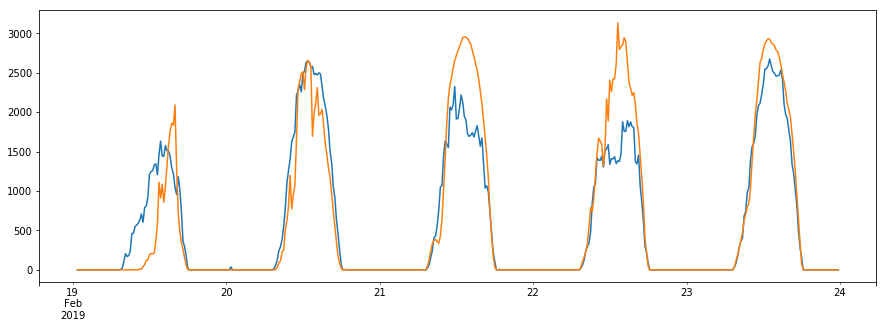

In [55]:
tester()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.1044 | r2 : 0.8234 | grade : 99.1665
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0940 | r2 : 0.7809 | grade : 117.8627
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0646 | r2 : 0.8532 | grade : 91.3323
--------------------------------------------------


feature  importance
12       Elevation_angle    0.525565
2                   hour    0.162204
5                    sky    0.071250
6   rainfall_probability    0.062768
13         Azimuth_angle    0.046161
4         temperature_3H    0.024345
9               humidity    0.024320
10            wind_speed    0.021175
14              dust_132    0.020835
1                    day    0.019284
11        wind_direction    0.008600
0                  month    0.008307
3                 minute    0.003054
7               rainfall    0.002023
8                   snow    0.000110
15              dirty_v2    0.000000

feature  importance
12       Elevation_angle    0.662410
2                   hour    0.083220
5                    sky    0.062458
13         Azimuth_angle    0.038269
6   rainfall_probability    0.033284
4         temperature_3H    0.025238
10            wind_speed    0.020926
9               humidity    0.020493
14              dust_132    0.018056
1                    day    0.015086
0                  month    0.009026
11        wind_direction    0.007449
3                 minute    0.002848
7               rainfall    0.001184
8                   snow    0.000051
15              dirty_v2    0.000000

feature  importance
12       Elevation_angle    0.601046
2                   hour    0.119358
5                    sky    0.051335
6   rainfall_probability    0.051164
13         Azimuth_angle    0.046852
4         temperature_3H    0.030129
10            wind_speed    0.022368
14              dust_132    0.021070
9               humidity    0.019148
1                    day    0.018243
11        wind_direction    0.007932
0                  month    0.006995
3                 minute    0.002992
7               rainfall    0.001276
8                   snow    0.000092
15              dirty_v2    0.000000

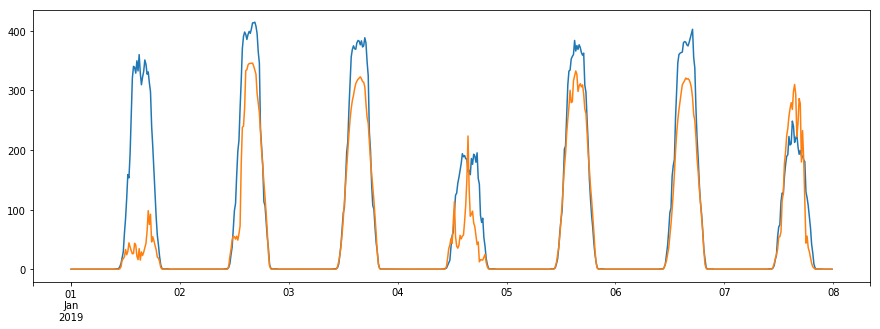

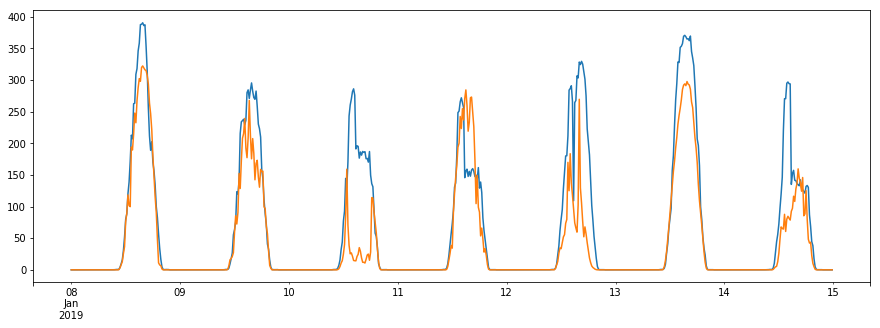

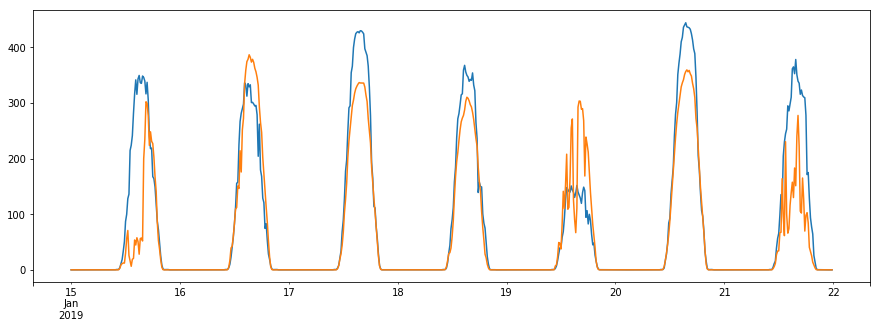

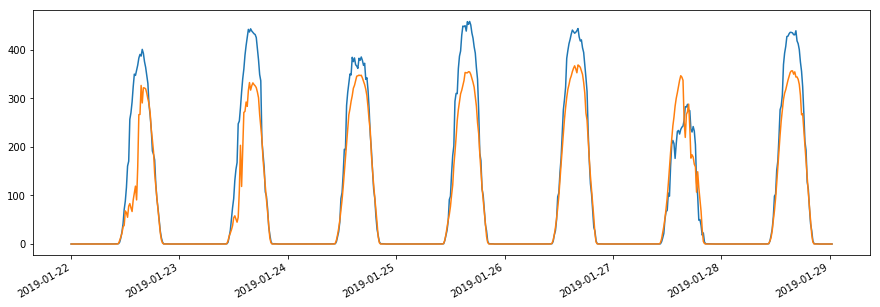

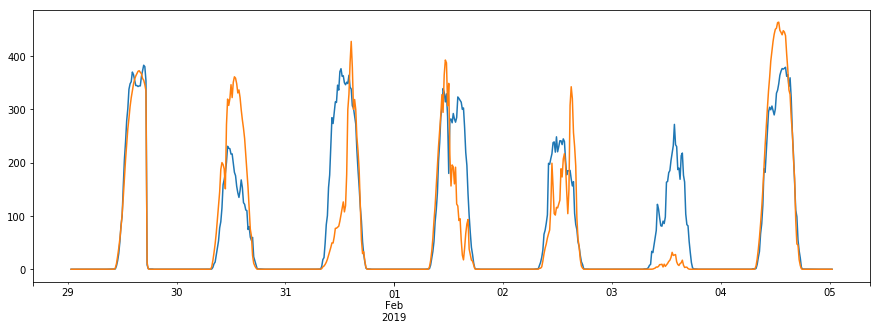

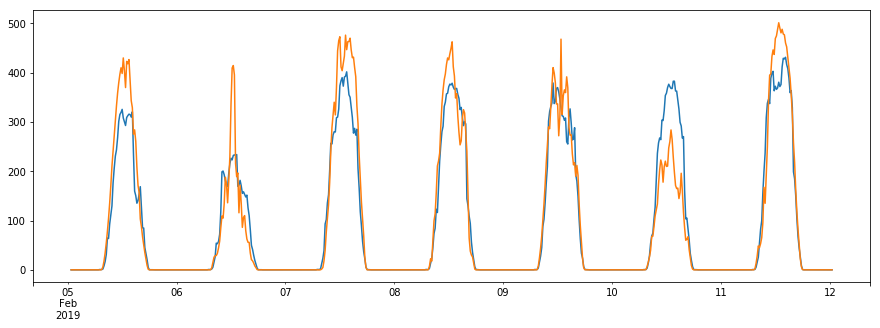

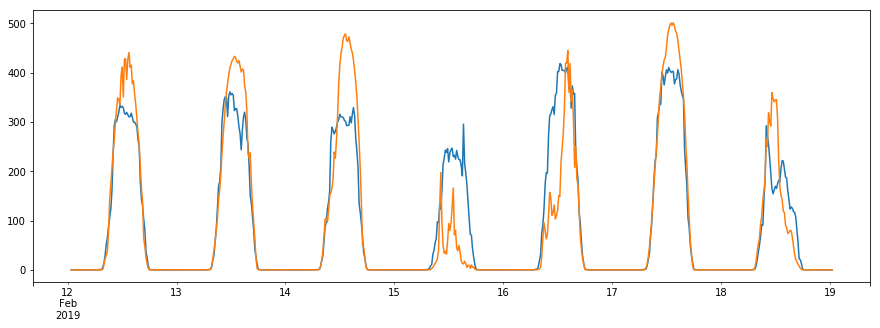

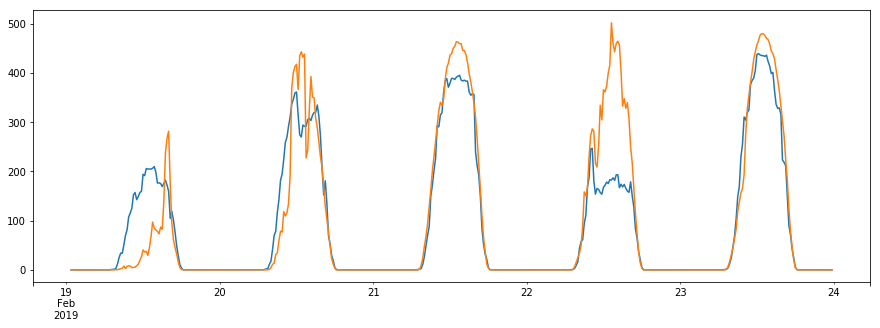

In [56]:
tester(target='B_Site')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.1060 | r2 : 0.8181 | grade : 98.9619
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0927 | r2 : 0.7872 | grade : 117.0789
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0616 | r2 : 0.8668 | grade : 87.0468
--------------------------------------------------


feature  importance
12       Elevation_angle    0.500883
2                   hour    0.176268
5                    sky    0.075604
6   rainfall_probability    0.059491
13         Azimuth_angle    0.058902
4         temperature_3H    0.024265
10            wind_speed    0.022505
9               humidity    0.021805
14              dust_132    0.020677
1                    day    0.017709
11        wind_direction    0.009632
0                  month    0.006923
3                 minute    0.003135
7               rainfall    0.002075
8                   snow    0.000125
15              dirty_v2    0.000000

feature  importance
12       Elevation_angle    0.586566
2                   hour    0.130276
13         Azimuth_angle    0.069195
5                    sky    0.060379
6   rainfall_probability    0.033478
4         temperature_3H    0.023407
9               humidity    0.021031
10            wind_speed    0.020499
14              dust_132    0.017625
1                    day    0.015254
0                  month    0.009908
11        wind_direction    0.008125
3                 minute    0.002962
7               rainfall    0.001245
8                   snow    0.000050
15              dirty_v2    0.000000

feature  importance
12       Elevation_angle    0.660712
2                   hour    0.069757
5                    sky    0.056871
6   rainfall_probability    0.046442
13         Azimuth_angle    0.040094
4         temperature_3H    0.027763
10            wind_speed    0.022040
14              dust_132    0.021384
9               humidity    0.018885
1                    day    0.017531
11        wind_direction    0.007702
0                  month    0.006345
3                 minute    0.003168
7               rainfall    0.001197
8                   snow    0.000109
15              dirty_v2    0.000000

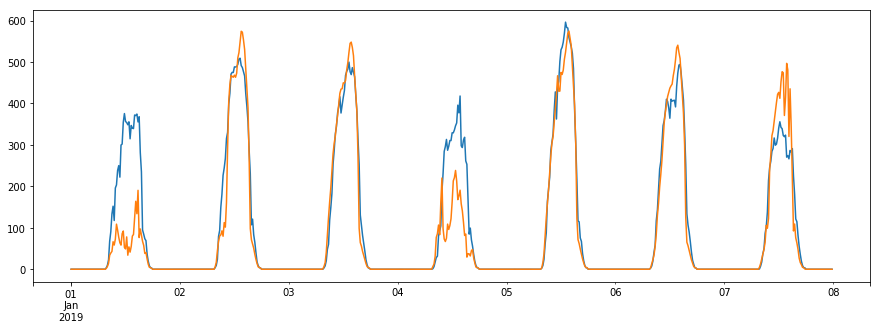

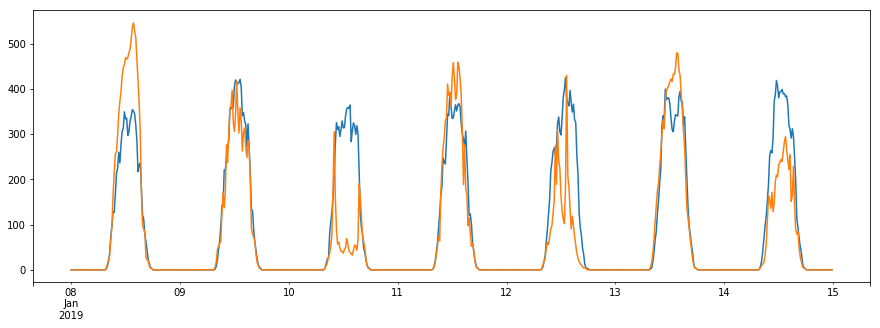

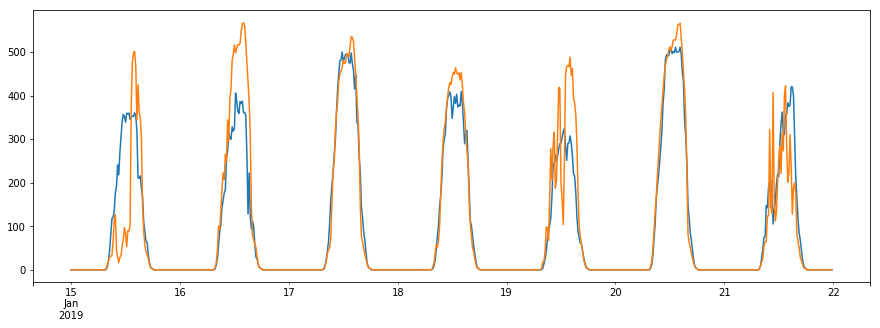

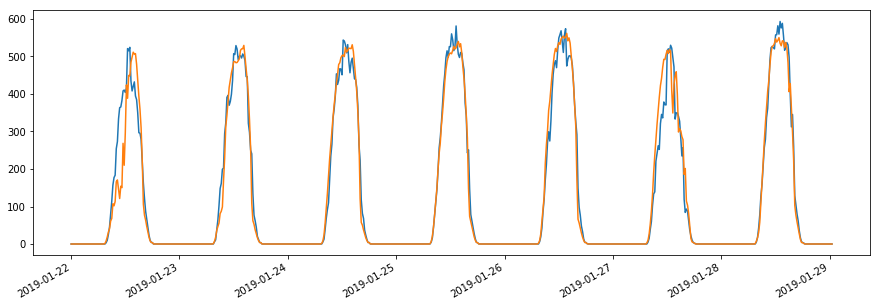

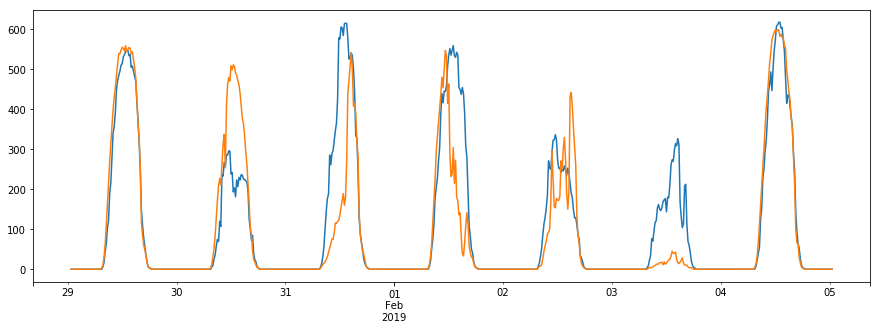

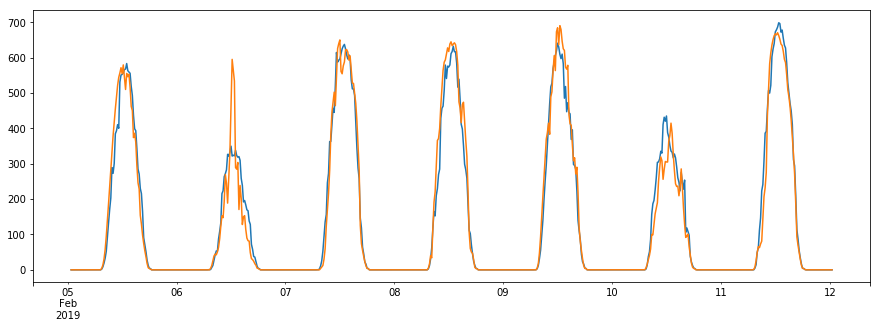

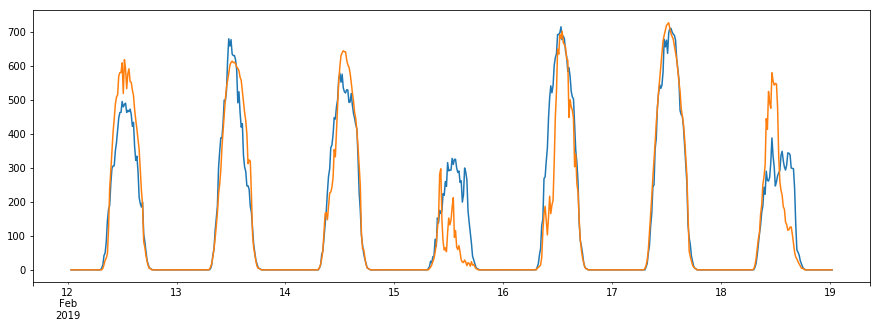

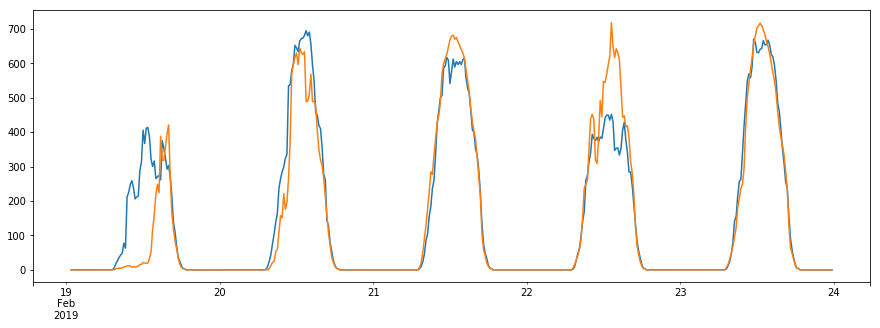

In [57]:
tester(target='C_Site')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.1060 | r2 : 0.8179 | grade : 99.3990
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0928 | r2 : 0.7865 | grade : 121.6632
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0624 | r2 : 0.8633 | grade : 83.8626
--------------------------------------------------


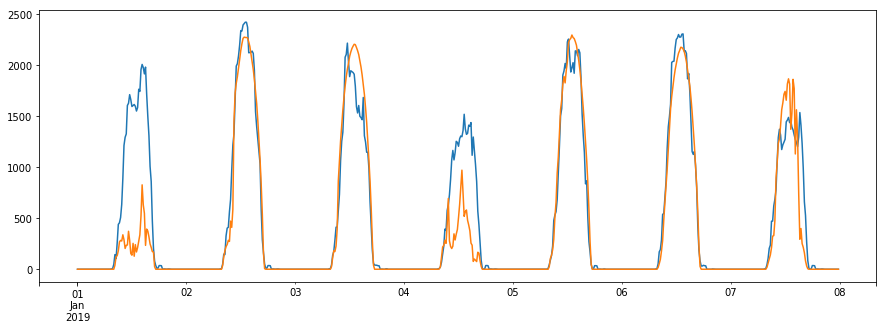

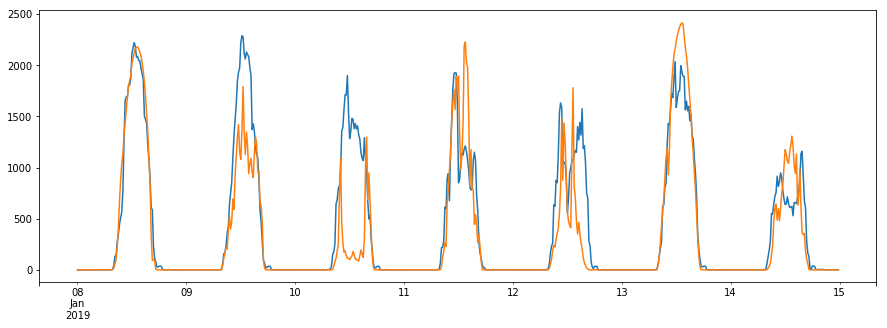

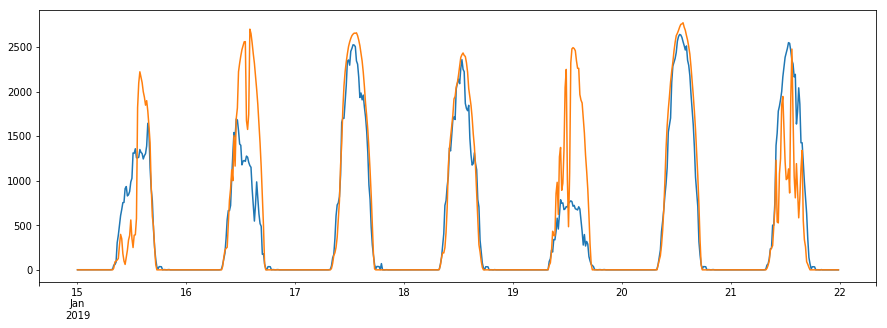

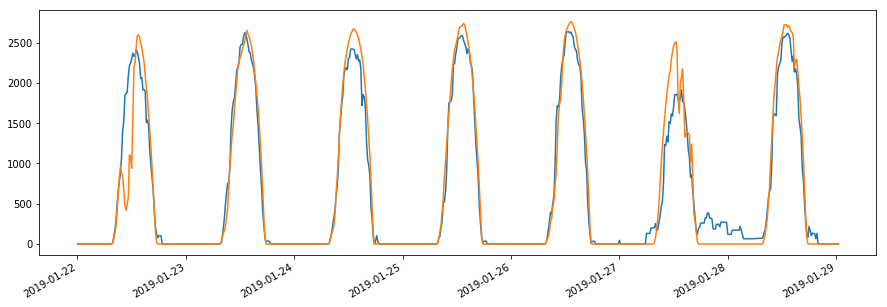

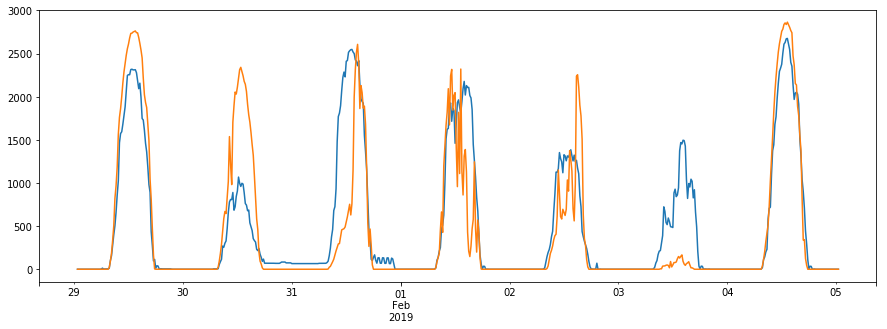

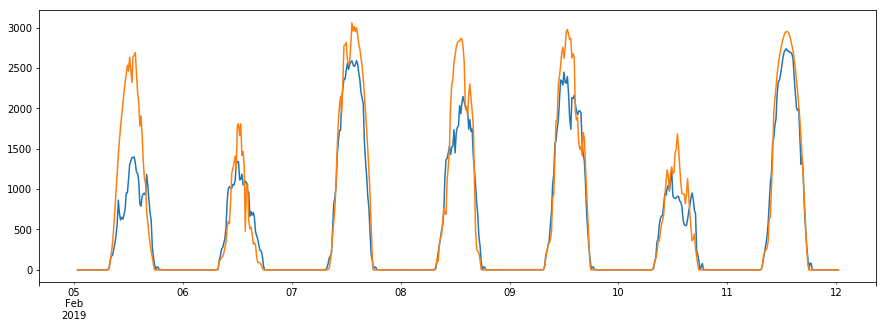

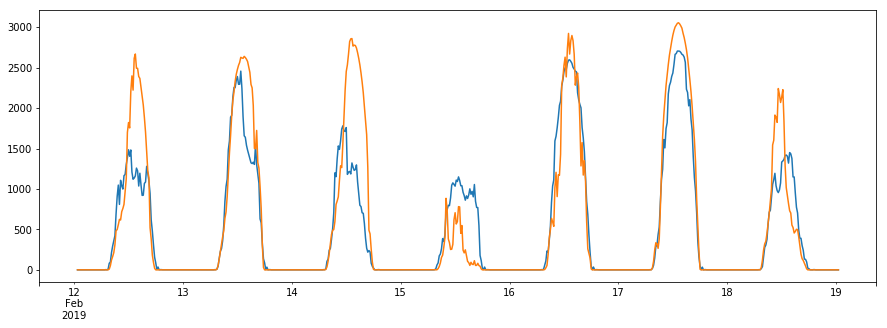

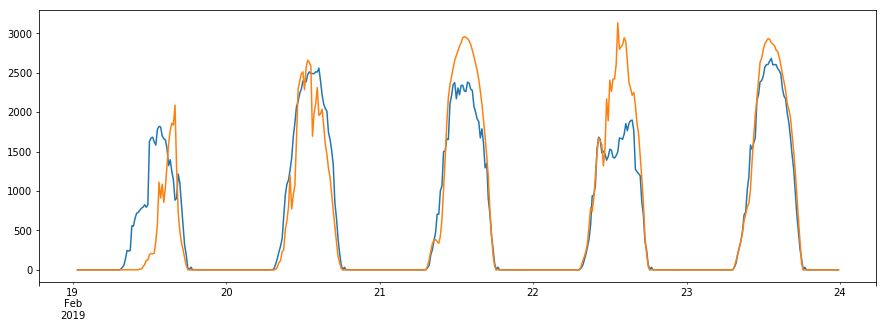

In [31]:
# dirty_v3 (exp 5)
tester()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.1077 | r2 : 0.8121 | grade : 97.2761
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0900 | r2 : 0.7991 | grade : 116.0678
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0623 | r2 : 0.8636 | grade : 88.3911
--------------------------------------------------


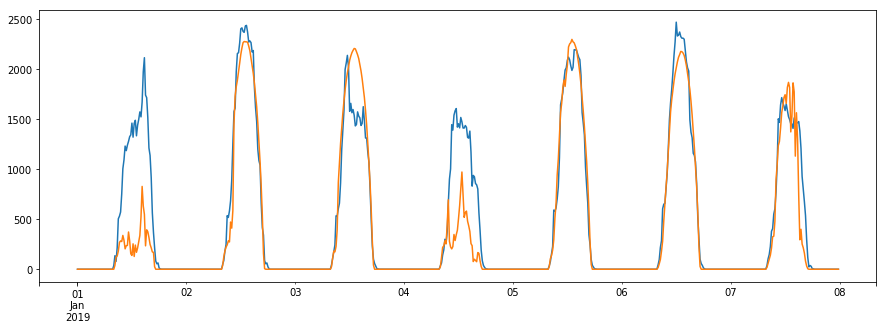

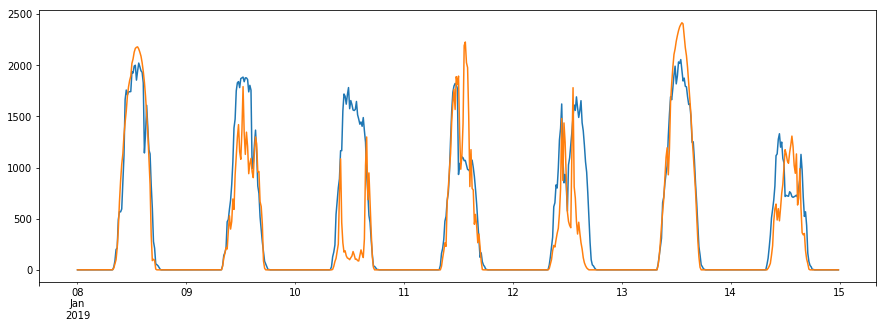

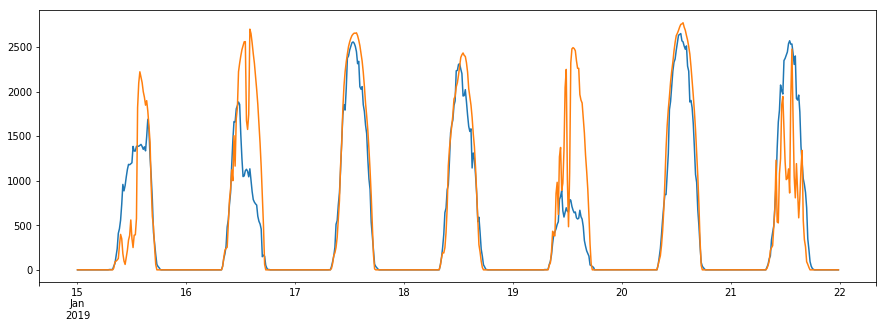

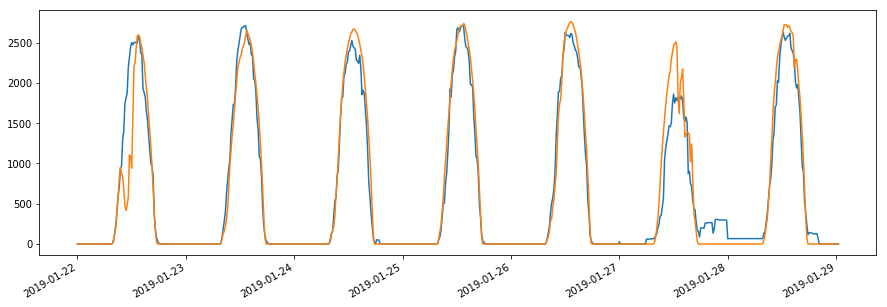

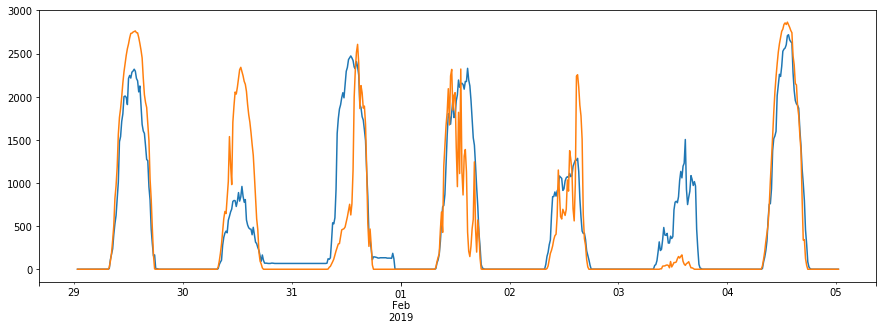

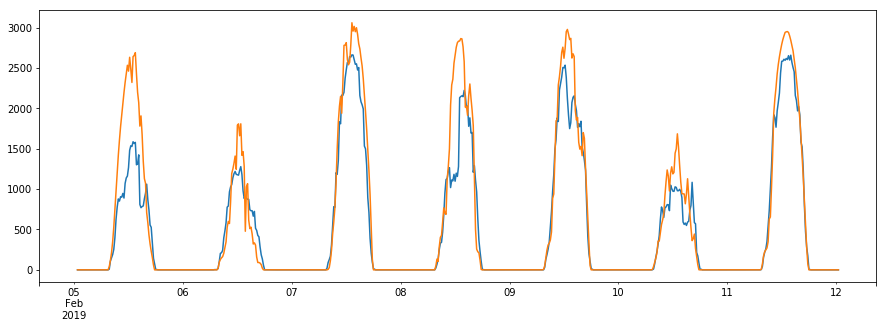

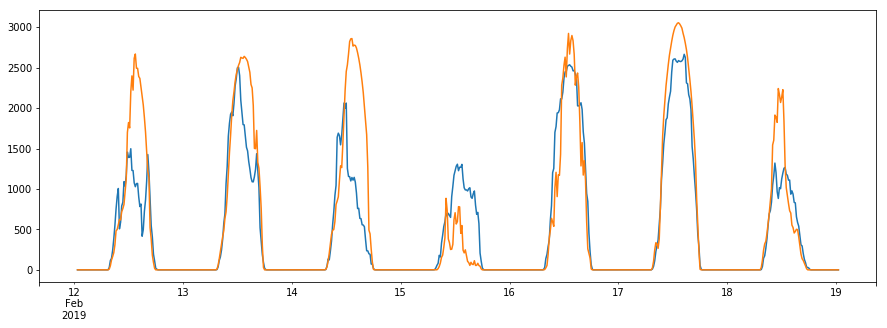

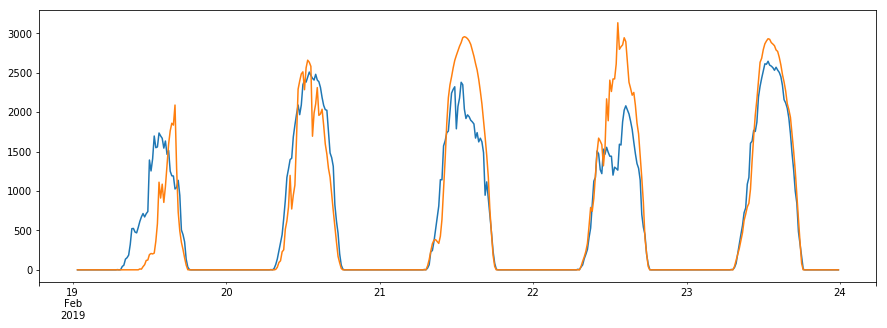

In [26]:
# dirty_v3 (exp 10)
tester()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.1077 | r2 : 0.8122 | grade : 97.0428
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0916 | r2 : 0.7920 | grade : 115.6022
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0609 | r2 : 0.8698 | grade : 83.9921
--------------------------------------------------


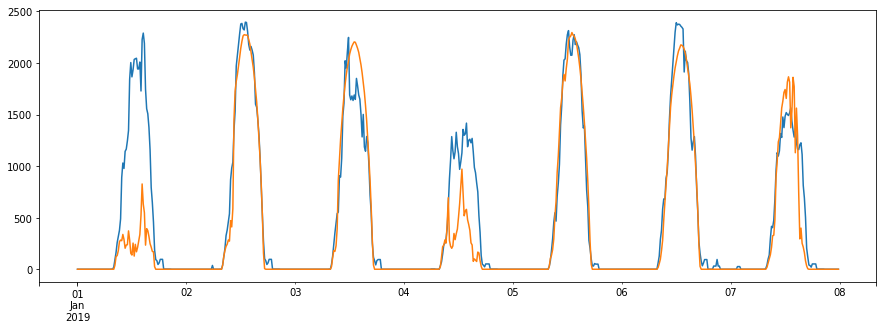

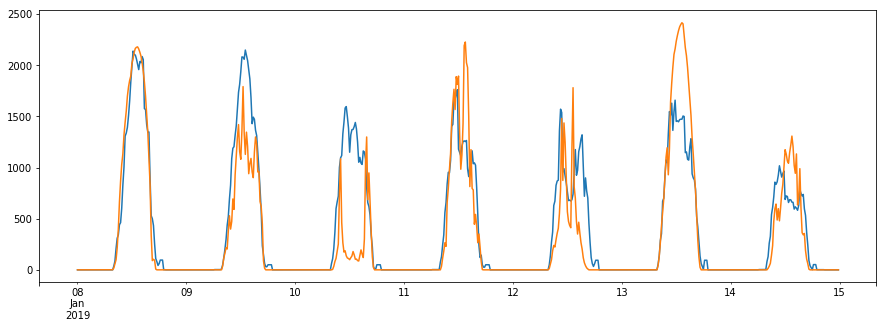

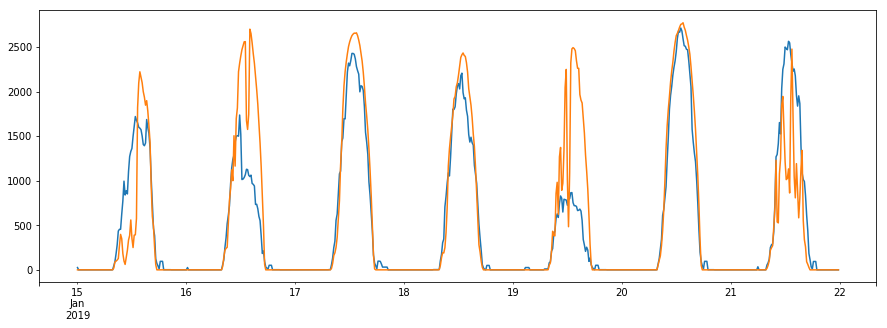

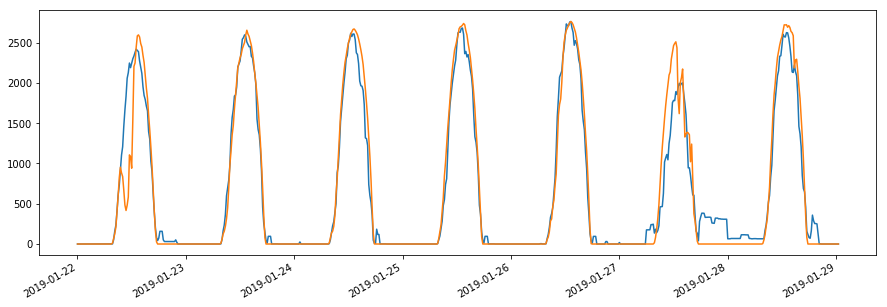

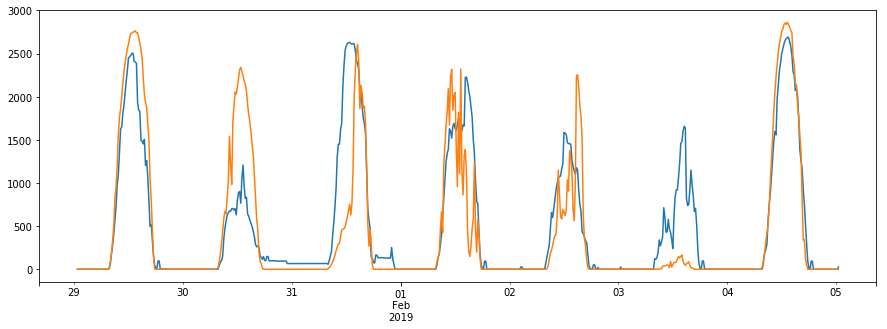

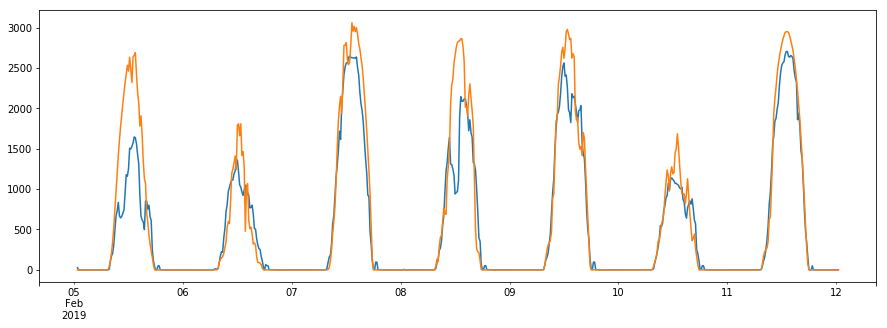

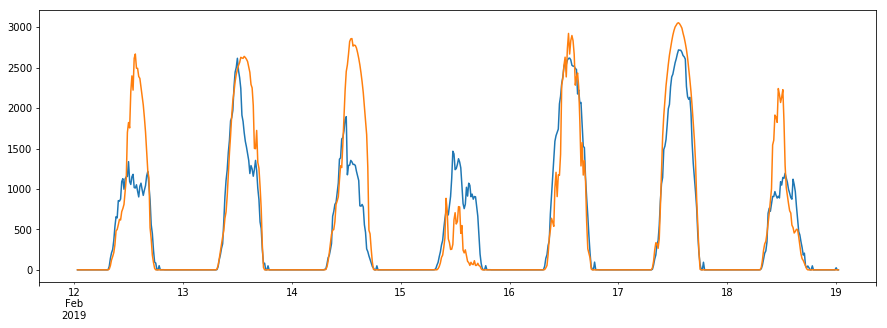

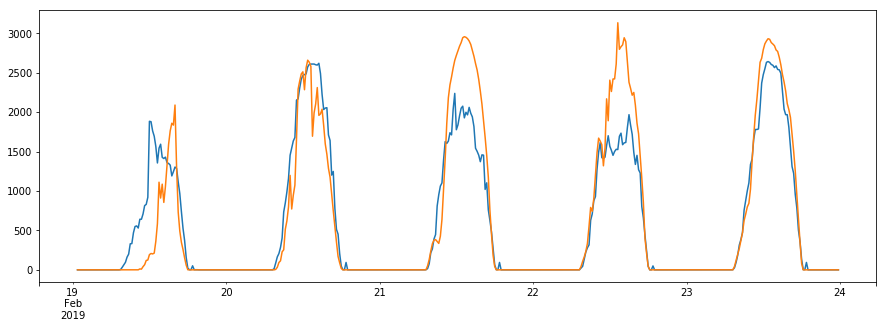

In [11]:
# dirty_v2
tester(columns_drop=[])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.1056 | r2 : 0.8193 | grade : 97.0791
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0927 | r2 : 0.7869 | grade : 110.8195
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0624 | r2 : 0.8630 | grade : 88.2658
--------------------------------------------------


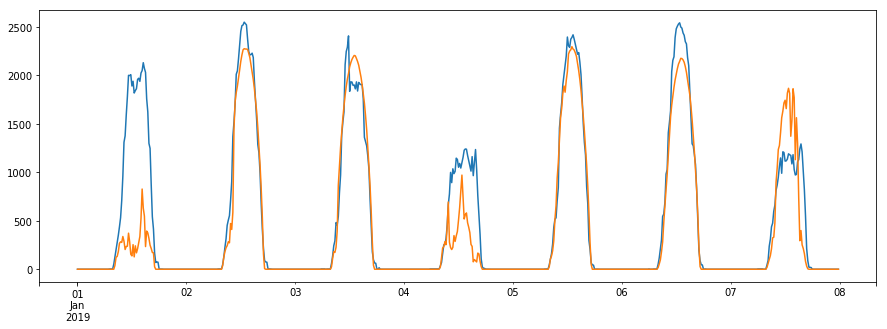

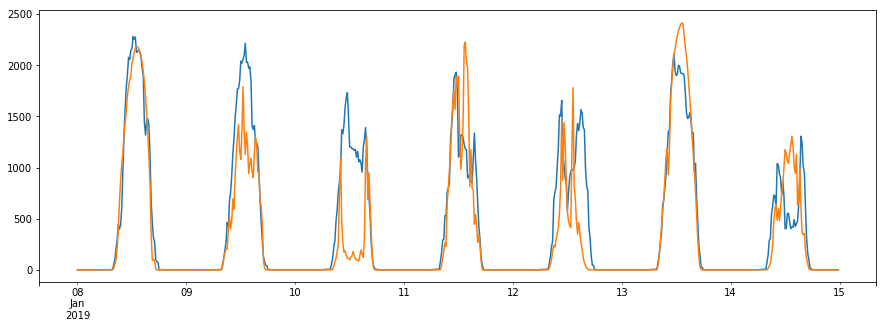

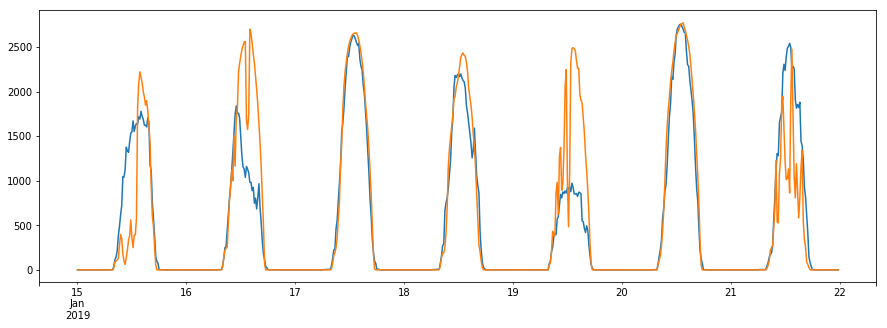

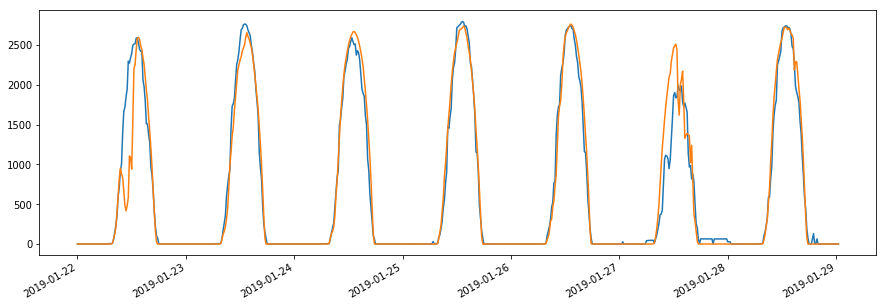

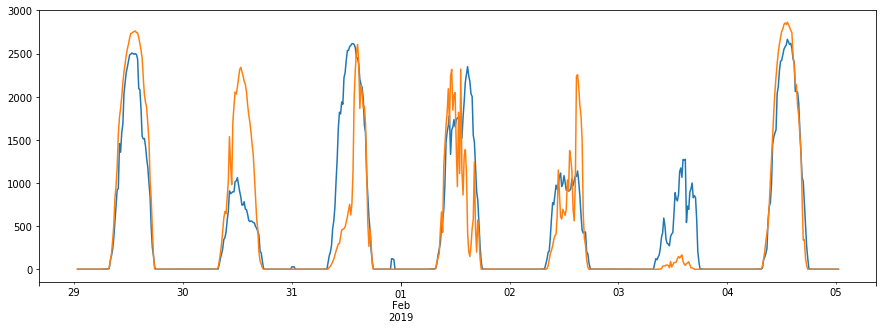

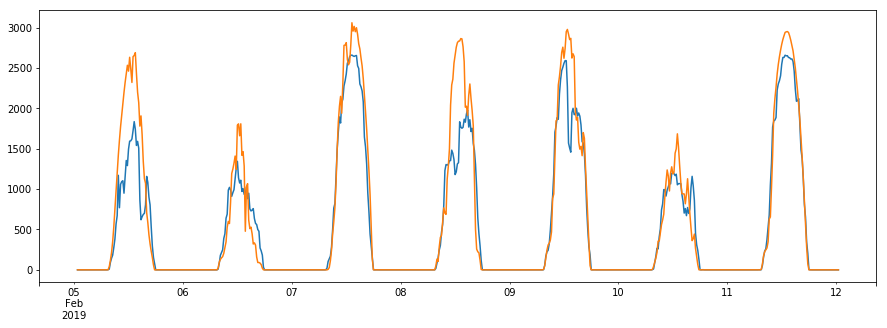

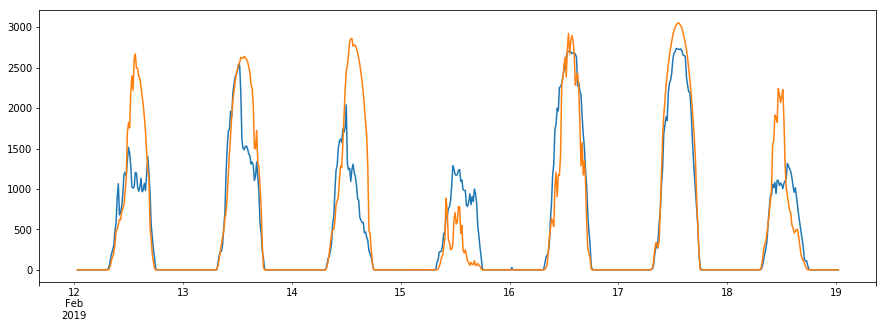

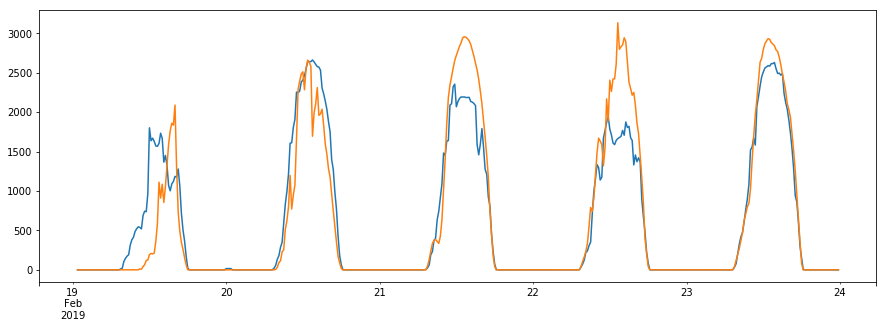

In [14]:
# normal
tester(columns_drop=[])

---

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


--------------------------------------------------


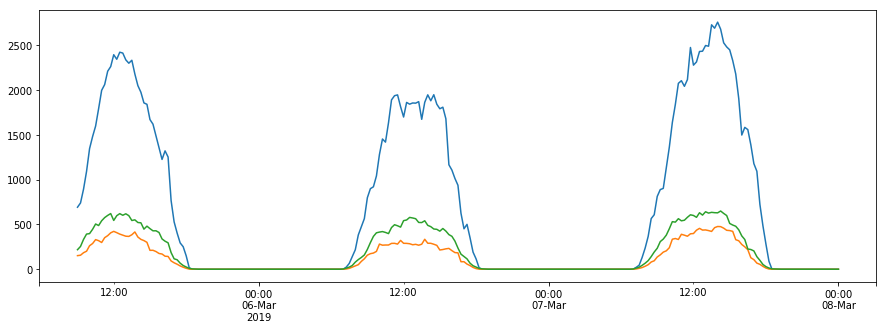

In [62]:
# quad
tester(columns_drop=[], test=True)

Index(['month', 'day', 'hour', 'minute', 'temperature_3H', 'sky',
       'rainfall_probability', 'rainfall', 'snow', 'humidity', 'wind_speed',
       'wind_direction', 'Elevation_angle', 'Azimuth_angle', 'dust_132'],
      dtype='object')
Index(['month', 'day', 'hour', 'minute', 'temperature_3H', 'sky',
       'rainfall_probability', 'rainfall', 'snow', 'humidity', 'wind_speed',
       'wind_direction', 'Elevation_angle', 'Azimuth_angle', 'dust_132'],
      dtype='object')


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


--------------------------------------------------
Index(['month', 'day', 'hour', 'minute', 'temperature_3H', 'sky',
       'rainfall_probability', 'rainfall', 'snow', 'humidity', 'wind_speed',
       'wind_direction', 'Elevation_angle', 'Azimuth_angle', 'dust_132'],
      dtype='object')
Index(['month', 'day', 'hour', 'minute', 'temperature_3H', 'sky',
       'rainfall_probability', 'rainfall', 'snow', 'humidity', 'wind_speed',
       'wind_direction', 'Elevation_angle', 'Azimuth_angle', 'dust_132'],
      dtype='object')


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


--------------------------------------------------
Index(['month', 'day', 'hour', 'minute', 'temperature_3H', 'sky',
       'rainfall_probability', 'rainfall', 'snow', 'humidity', 'wind_speed',
       'wind_direction', 'Elevation_angle', 'Azimuth_angle', 'dust_132'],
      dtype='object')
Index(['month', 'day', 'hour', 'minute', 'temperature_3H', 'sky',
       'rainfall_probability', 'rainfall', 'snow', 'humidity', 'wind_speed',
       'wind_direction', 'Elevation_angle', 'Azimuth_angle', 'dust_132'],
      dtype='object')


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:89: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


--------------------------------------------------


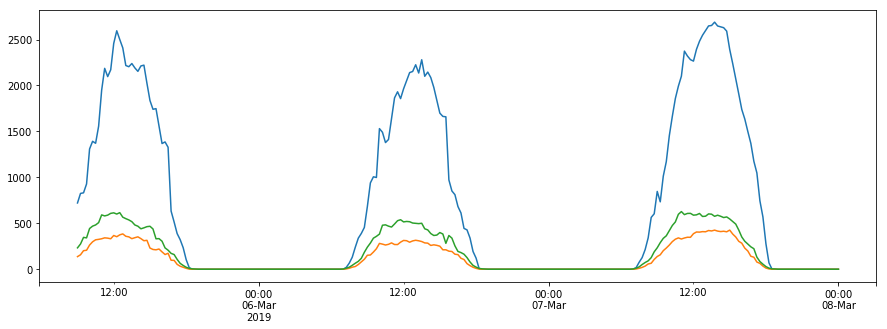

In [56]:
tester(columns_drop=[], test=True)

### variable testing

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.1056 | r2 : 0.8195 | grade : 97.3951
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0941 | r2 : 0.7804 | grade : 124.3458
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0624 | r2 : 0.8632 | grade : 86.6585
--------------------------------------------------


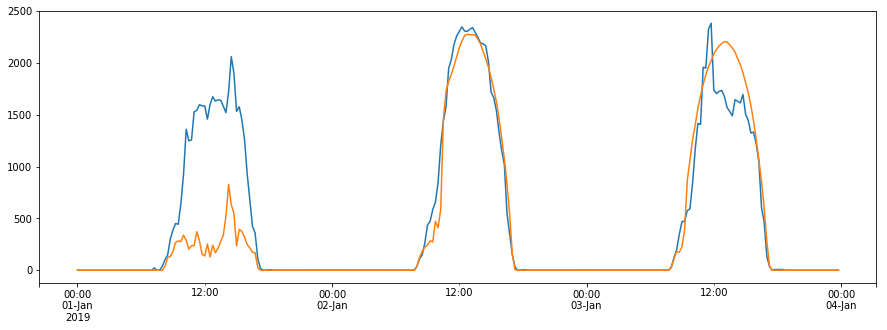

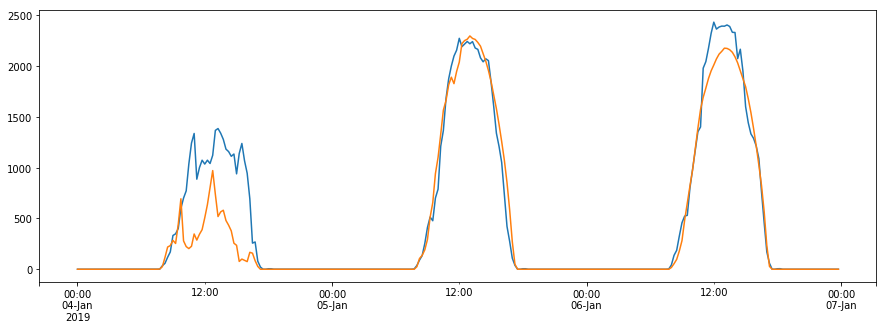

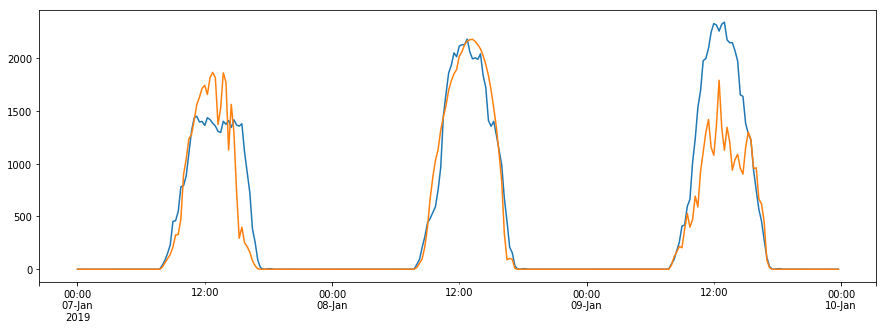

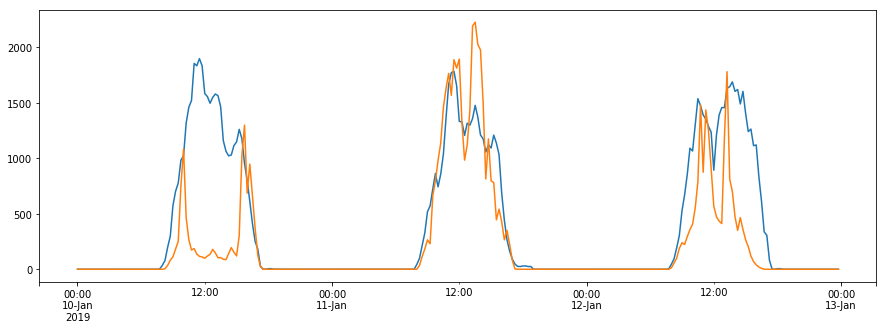

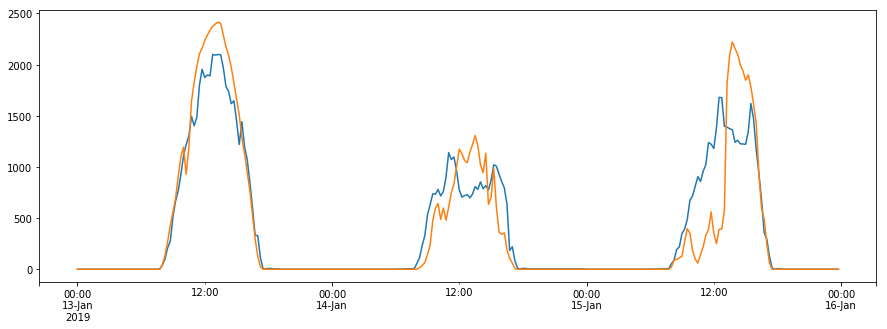

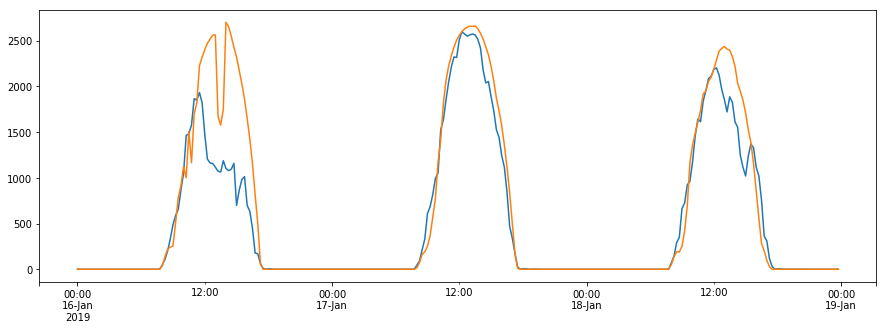

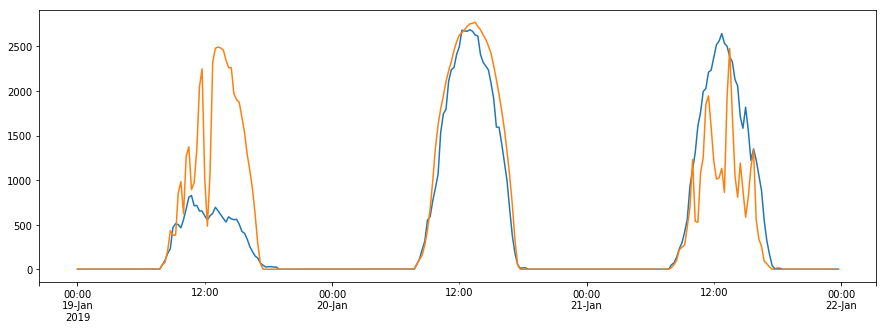

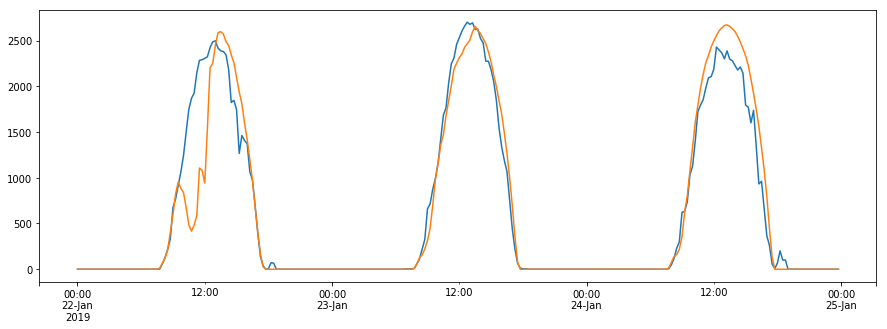

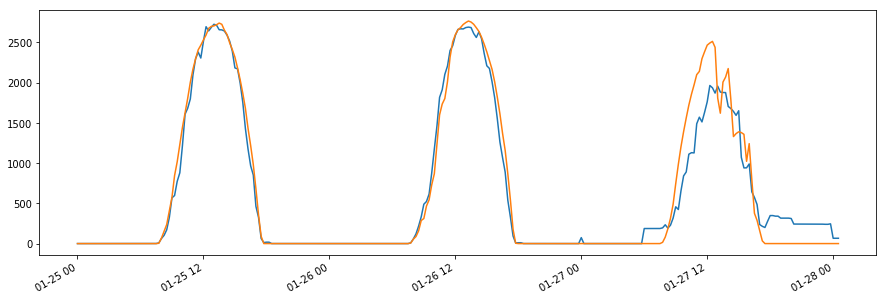

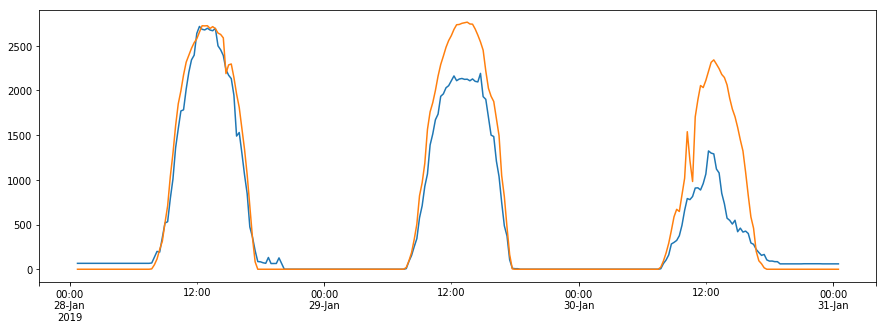

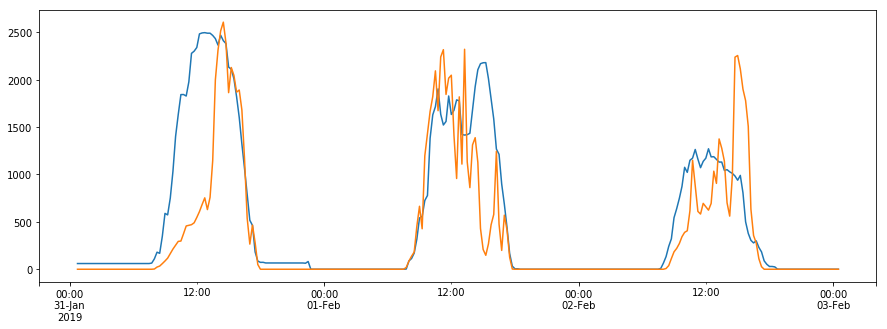

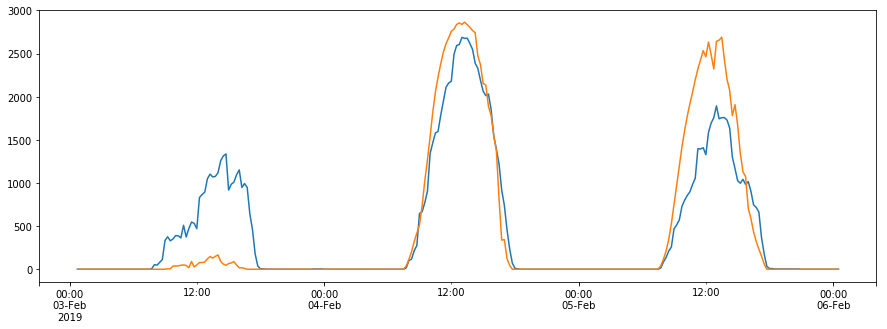

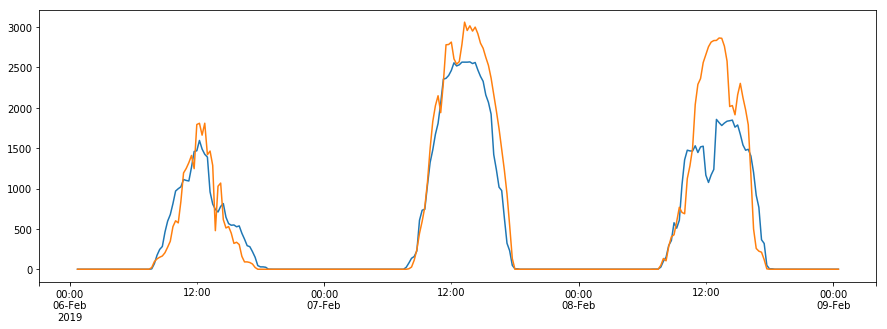

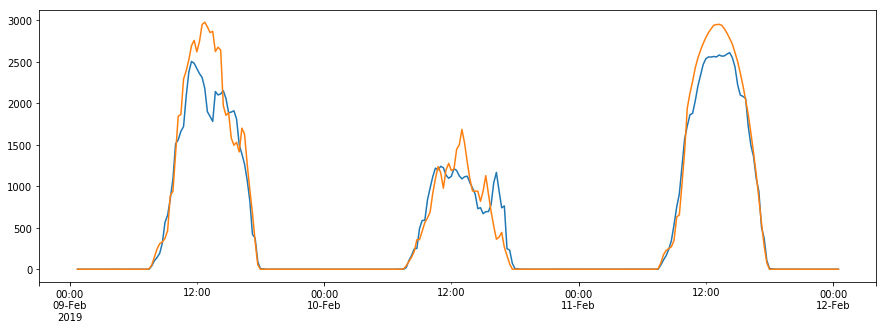

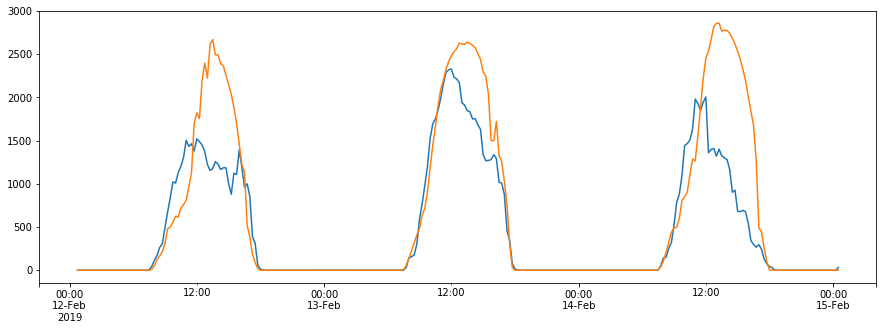

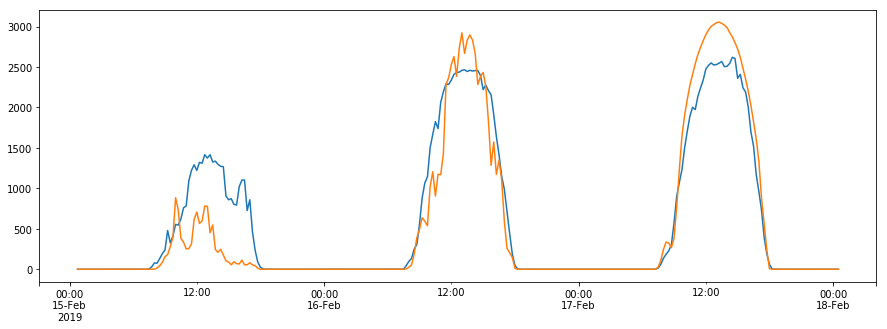

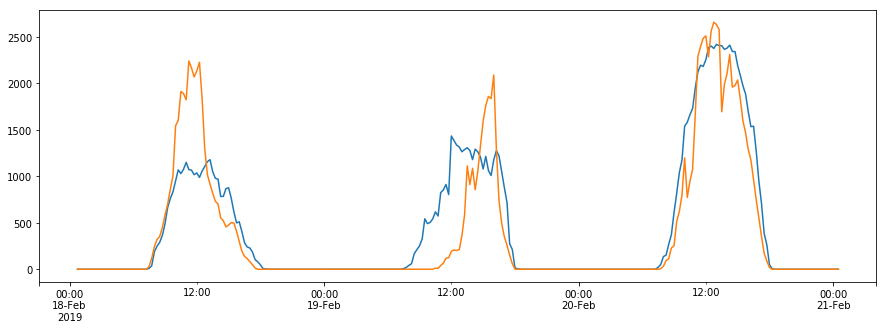

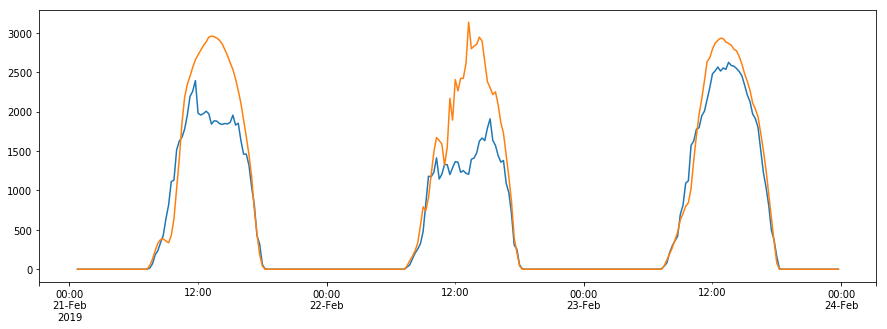

In [31]:
# dirty(no rainfall)
tester(days=3)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.1041 | r2 : 0.8243 | grade : 94.7953
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0930 | r2 : 0.7857 | grade : 115.4982
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0635 | r2 : 0.8584 | grade : 87.4350
--------------------------------------------------


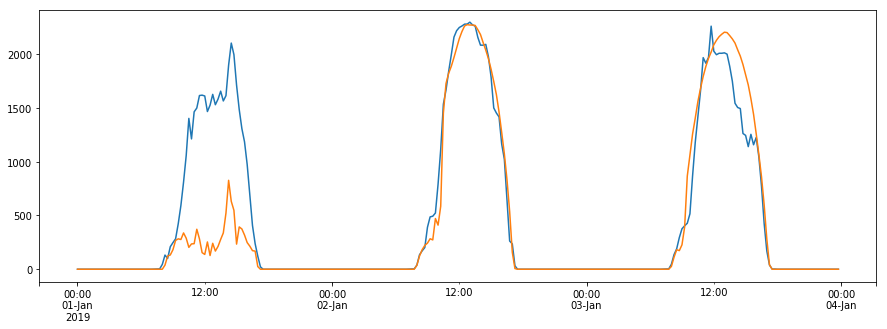

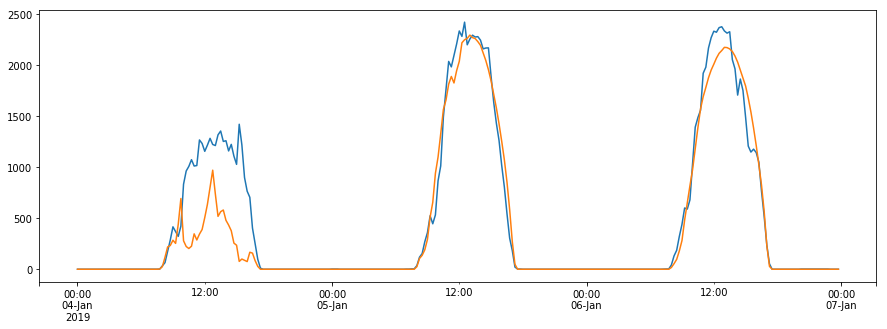

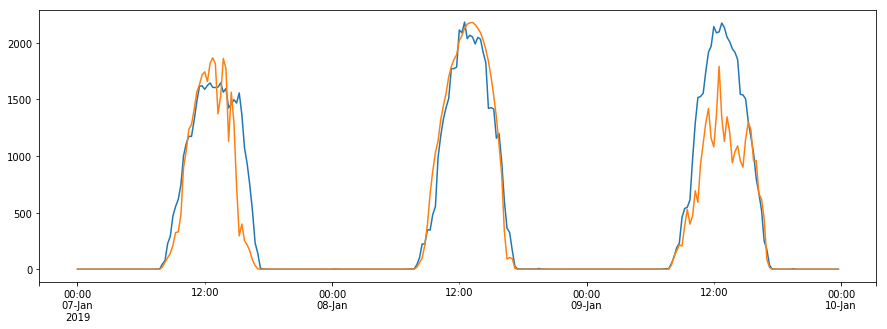

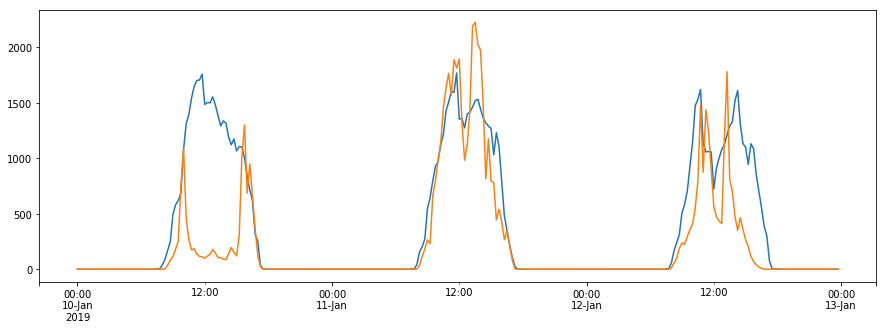

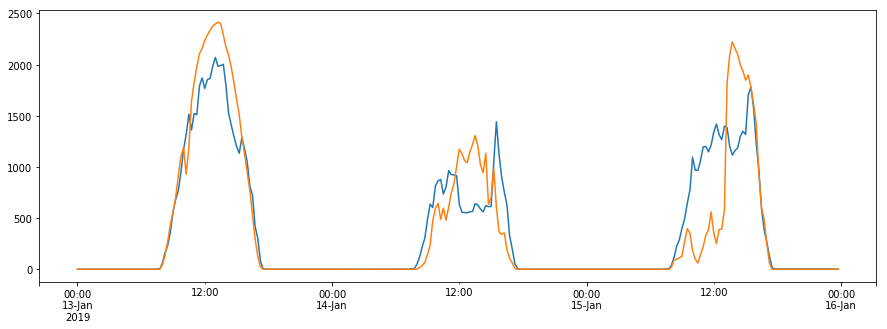

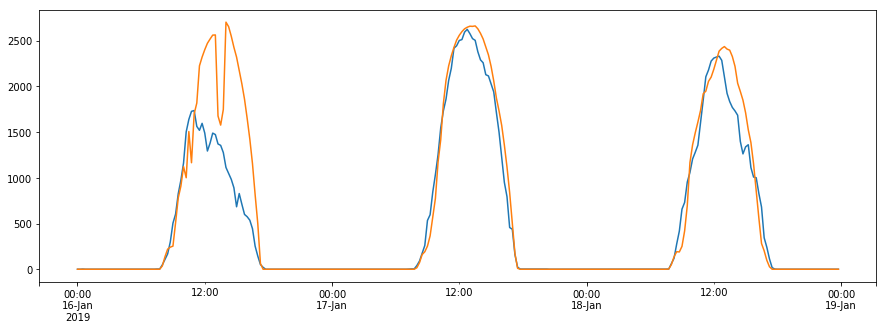

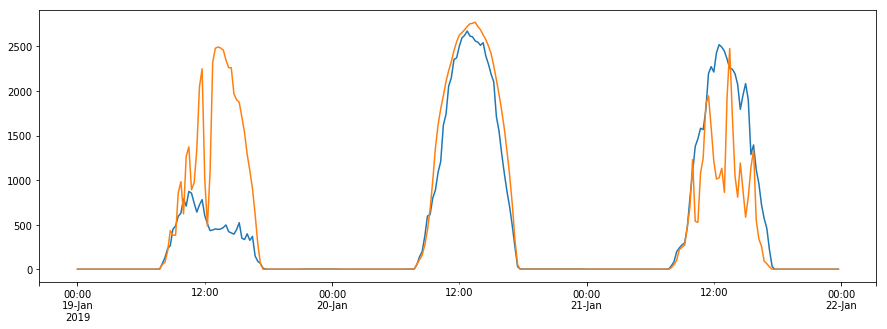

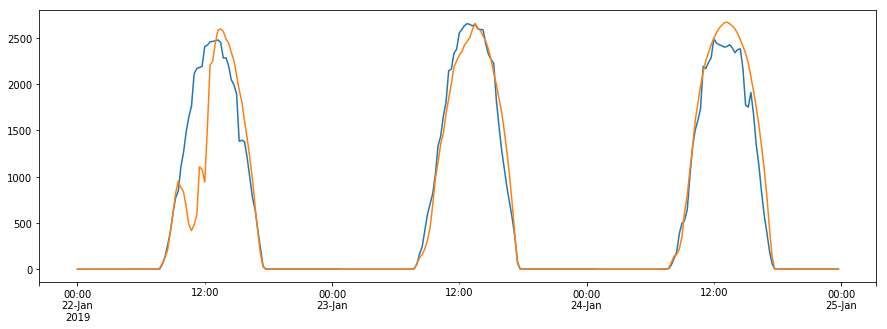

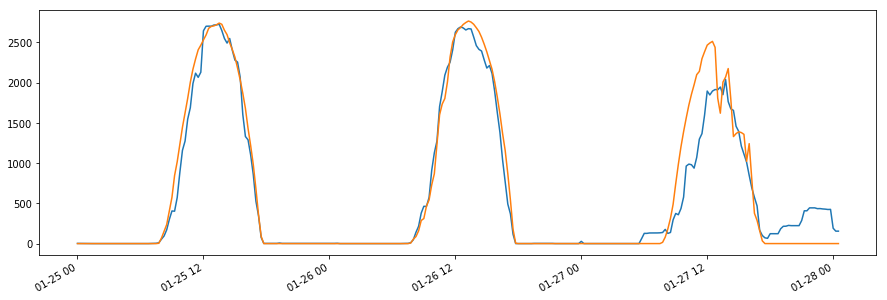

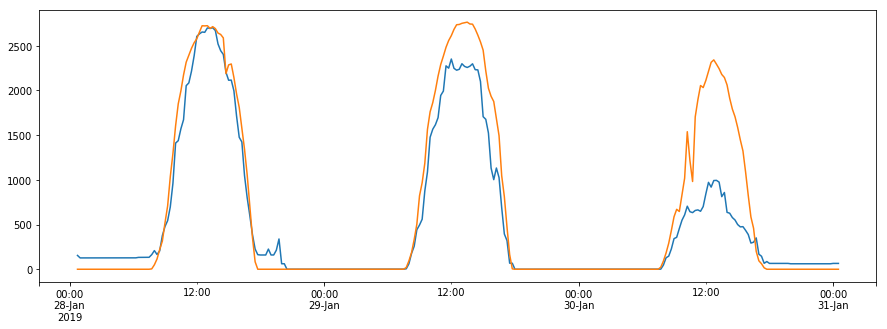

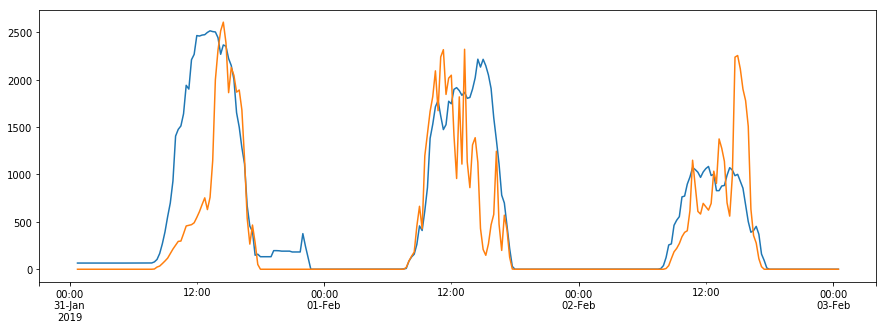

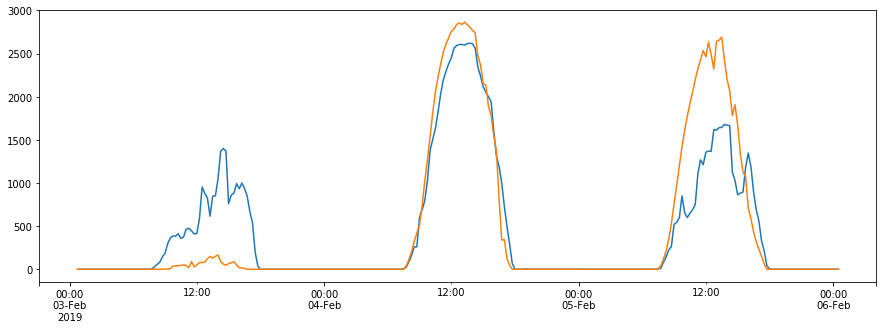

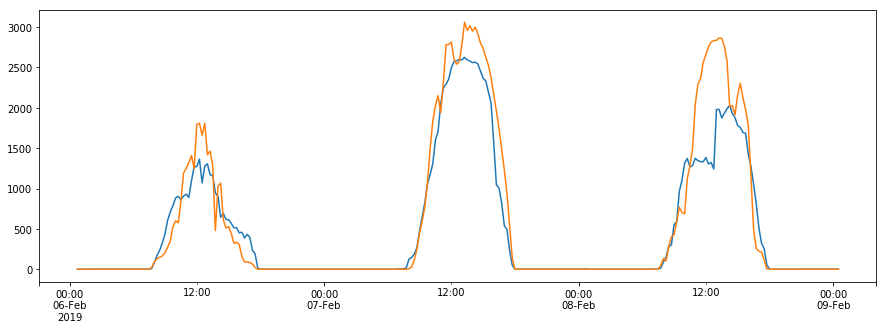

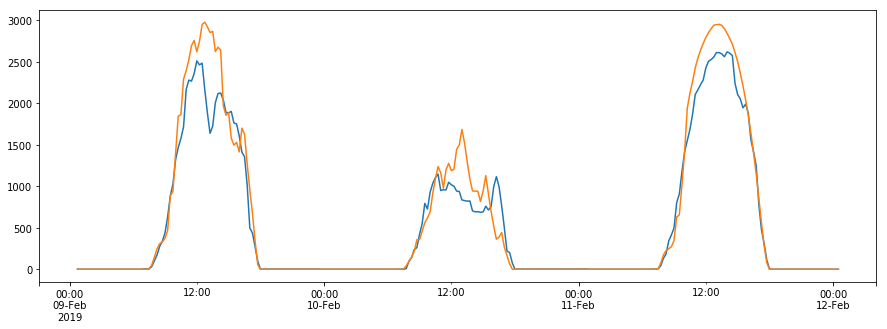

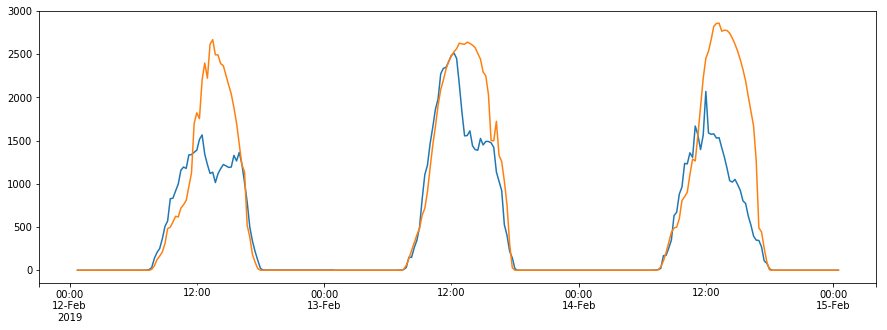

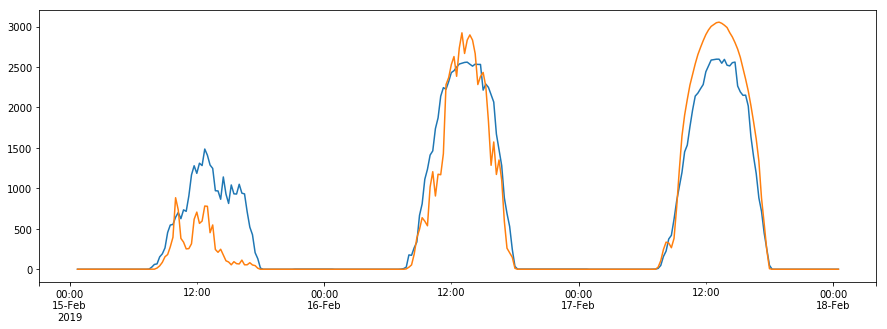

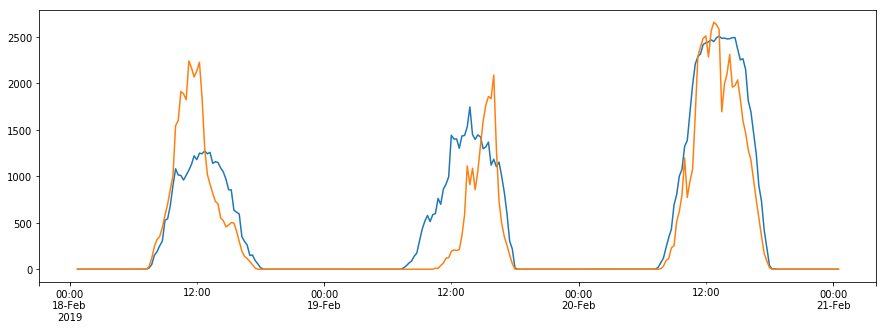

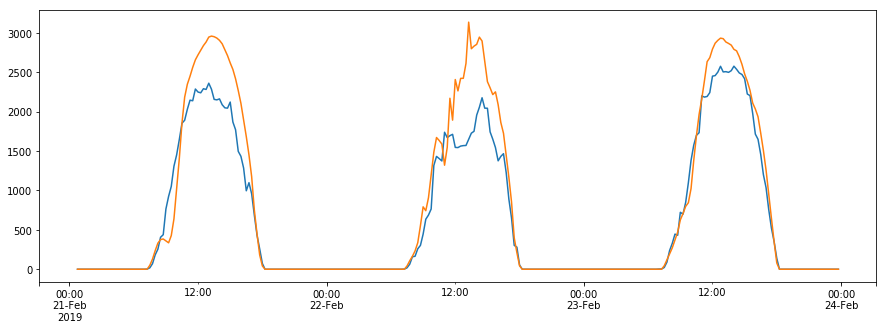

In [29]:
# 'Elevation_angle', 'Azimuth_angle' X
tester(days=3)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.1094 | r2 : 0.8062 | grade : 107.3147
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0981 | r2 : 0.7615 | grade : 132.6213
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0643 | r2 : 0.8547 | grade : 86.5309
--------------------------------------------------


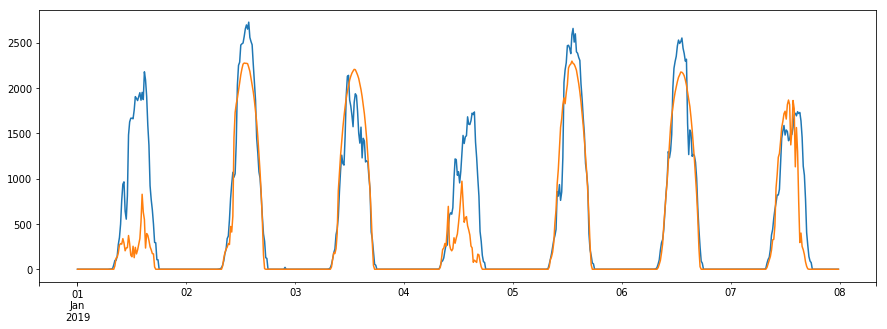

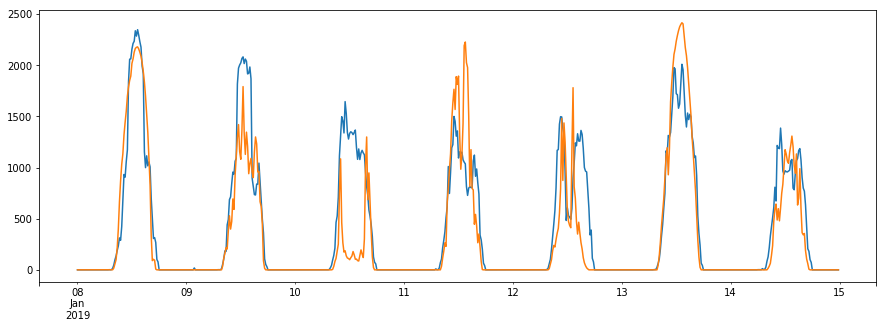

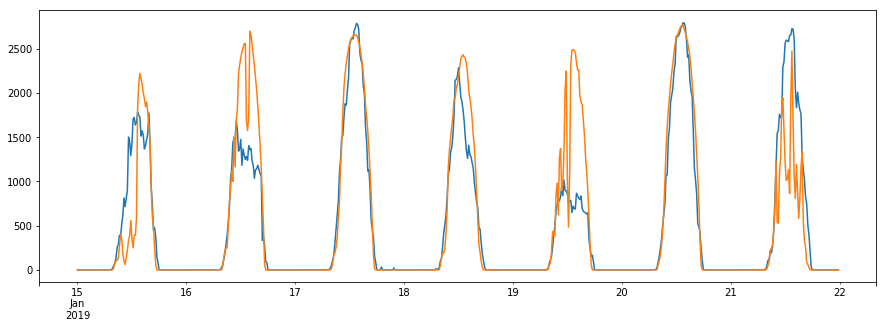

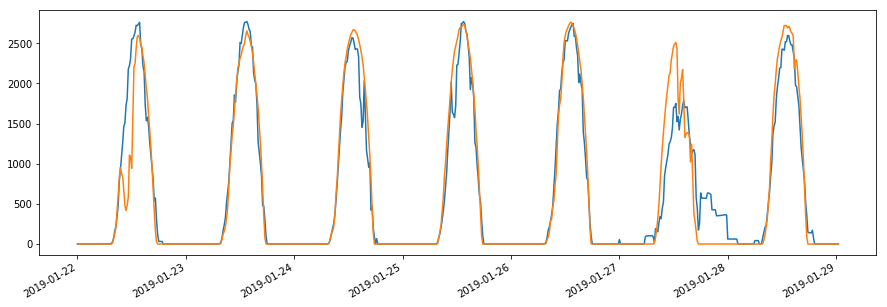

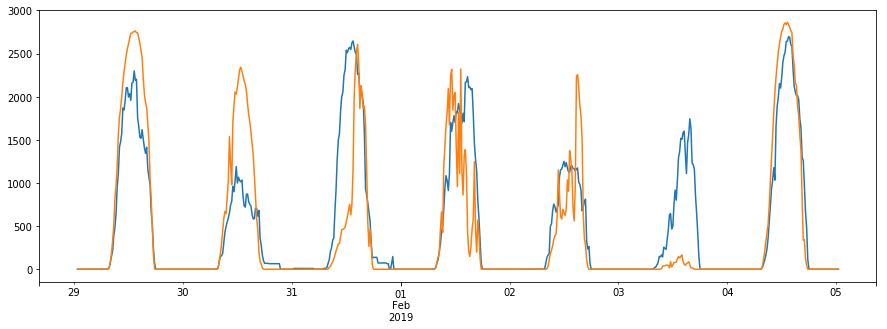

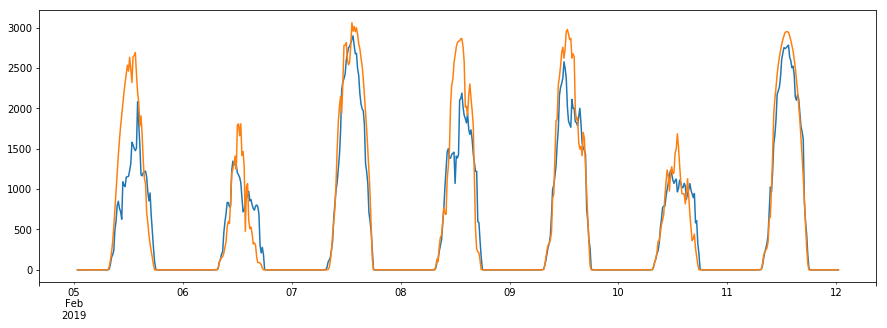

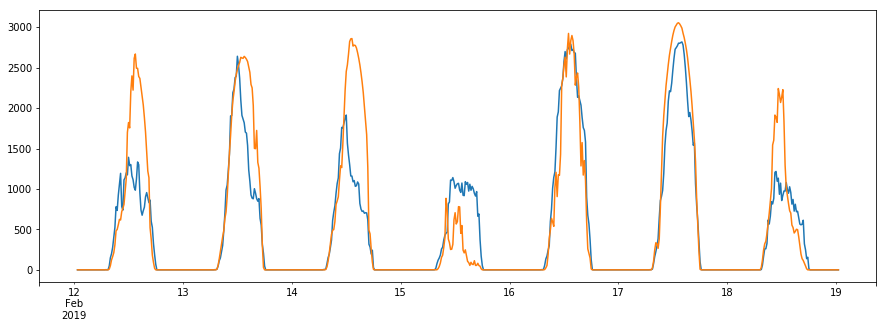

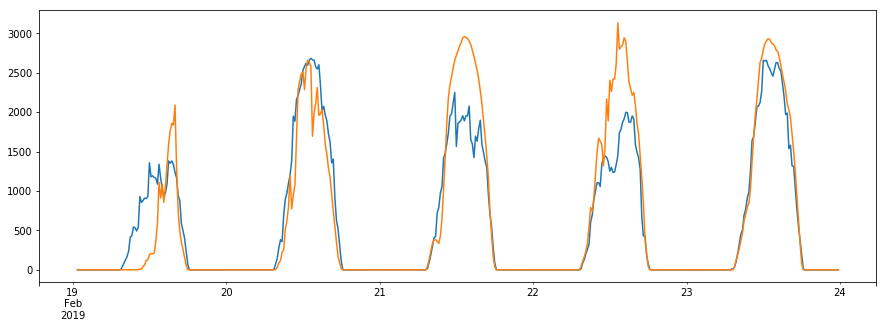

In [190]:
# 'Elevation_angle', 'Azimuth_angle' O
tester(columns_drop=[])

### algorithm testing

rmse : 0.2480 | r2 : 0.0036 | grade : 317.0989
--------------------------------------------------
rmse : 0.1602 | r2 : 0.3642 | grade : 197.1013
--------------------------------------------------
rmse : 0.0974 | r2 : 0.6664 | grade : 125.2911
--------------------------------------------------


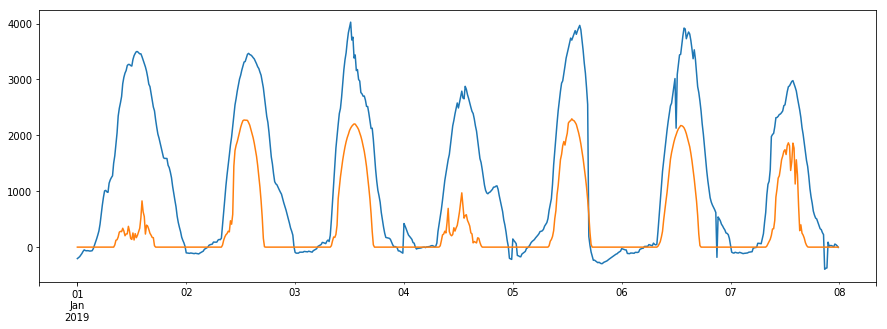

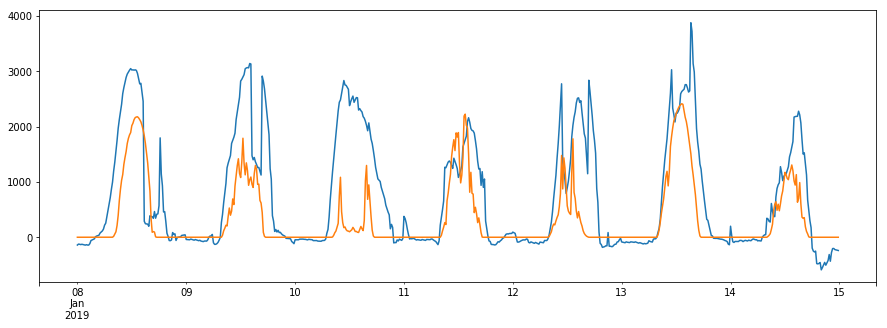

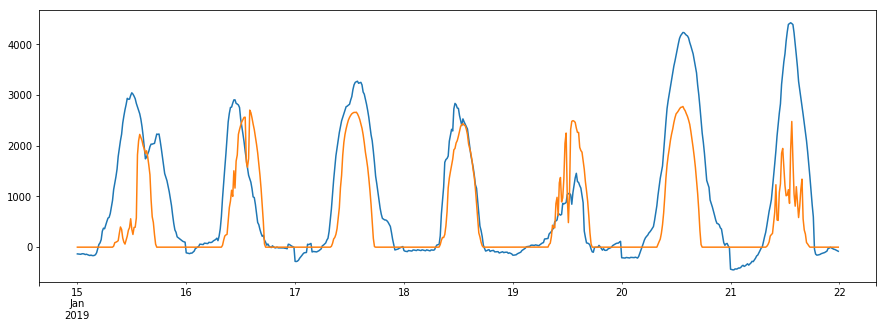

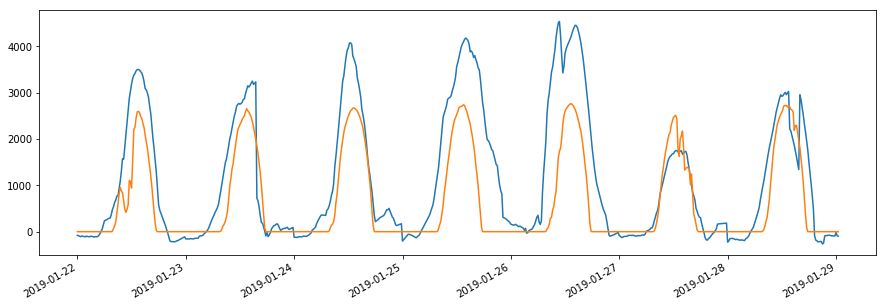

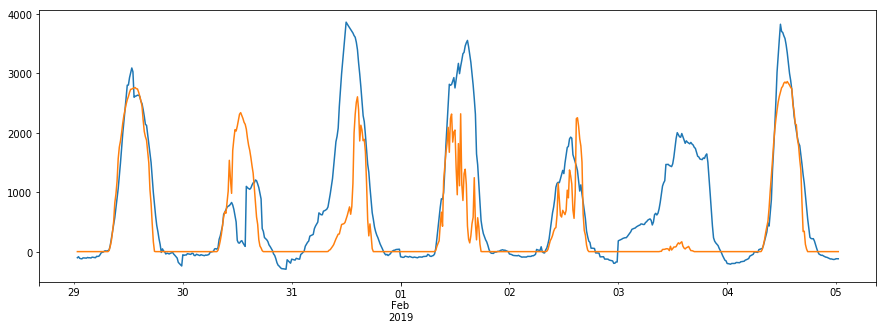

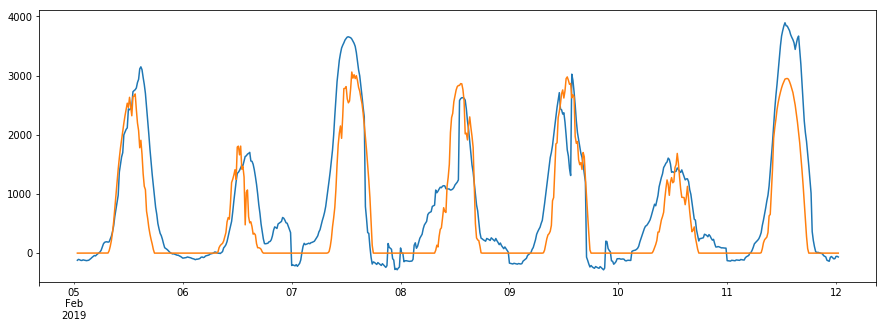

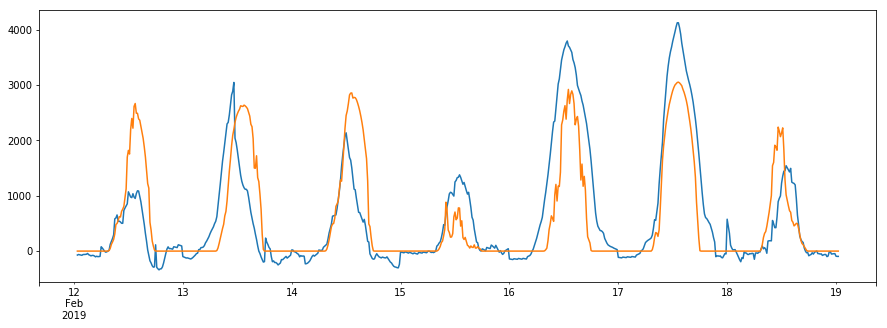

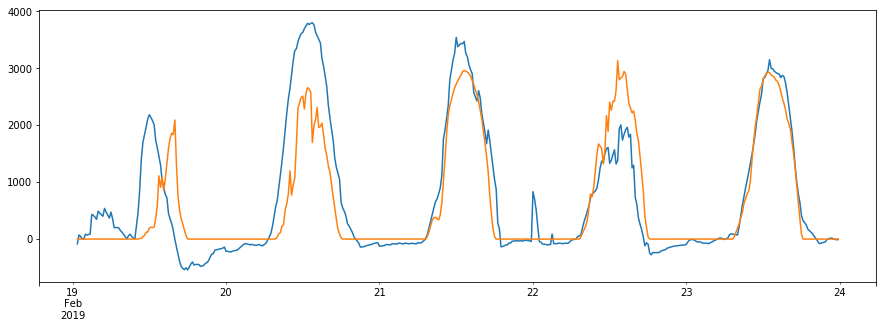

In [181]:
# NN
tester(model='NN')

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


rmse : 0.1272 | r2 : 0.7379 | grade : 183.2919
--------------------------------------------------


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


rmse : 0.0978 | r2 : 0.7628 | grade : 157.8059
--------------------------------------------------


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


rmse : 0.0672 | r2 : 0.8413 | grade : 113.8424
--------------------------------------------------


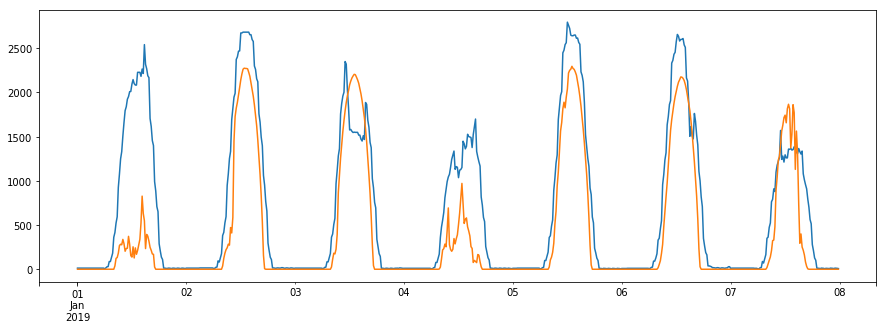

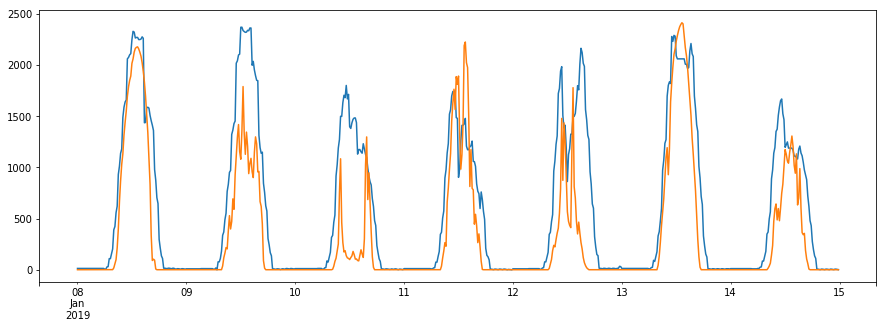

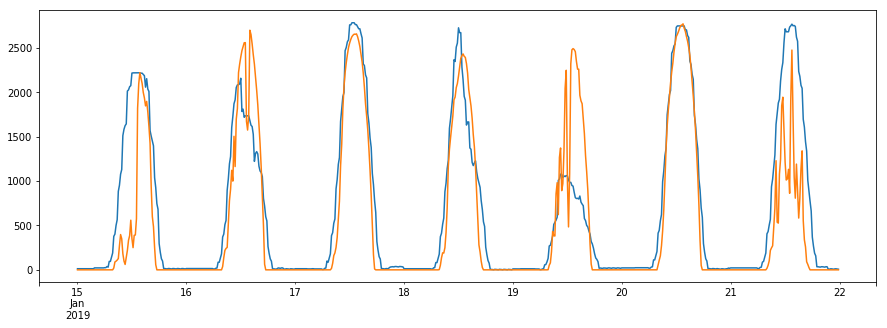

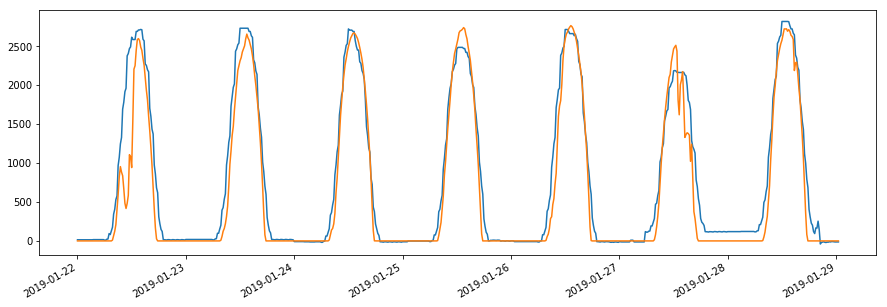

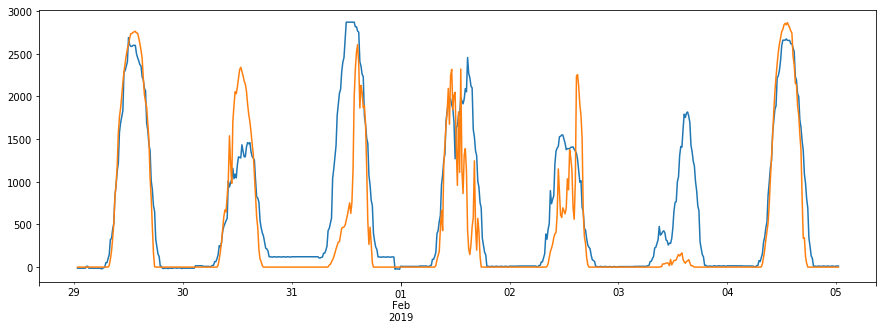

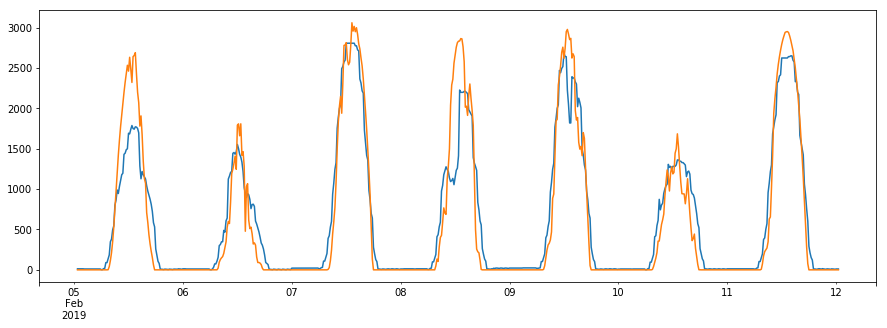

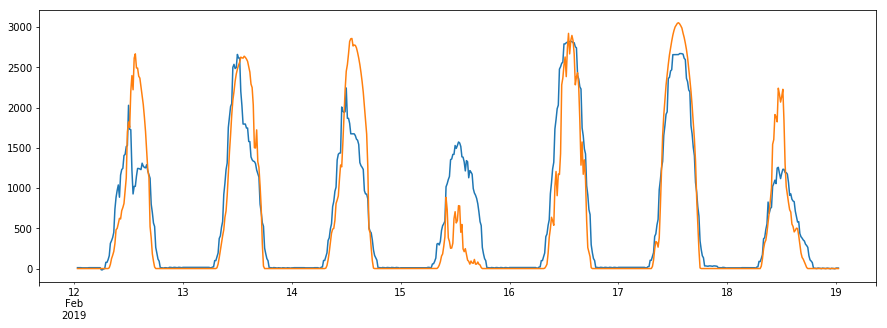

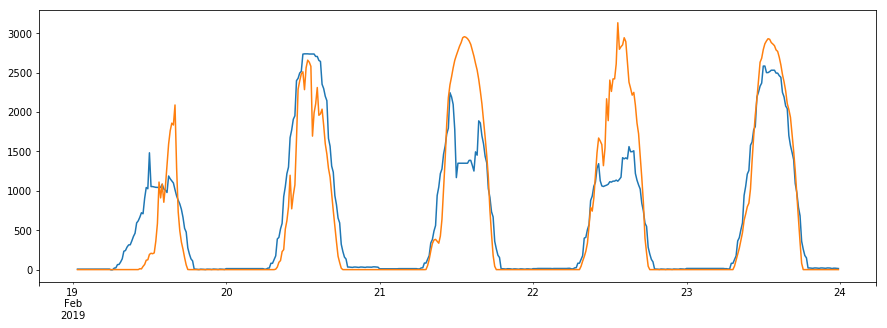

In [169]:
# lgb
tester(days=7, model='lgb')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.1247 | r2 : 0.7482 | grade : 165.1209
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0980 | r2 : 0.7618 | grade : 138.3949
--------------------------------------------------


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


rmse : 0.0687 | r2 : 0.8339 | grade : 105.7363
--------------------------------------------------


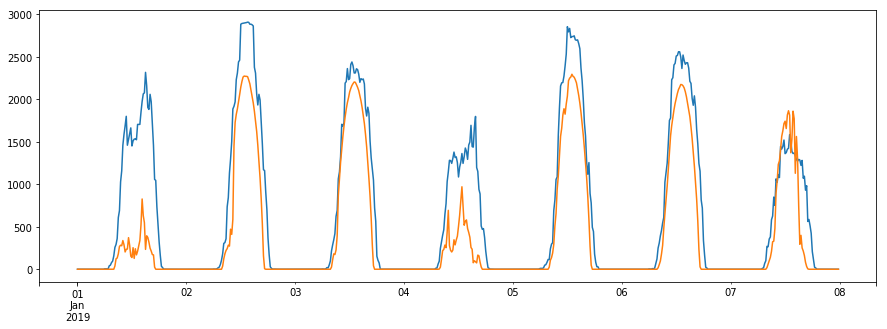

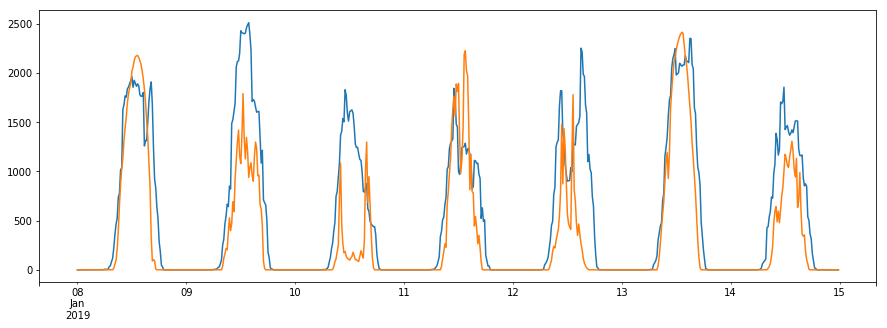

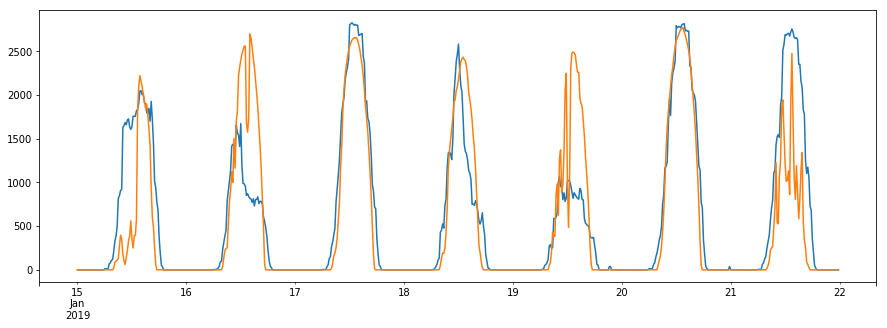

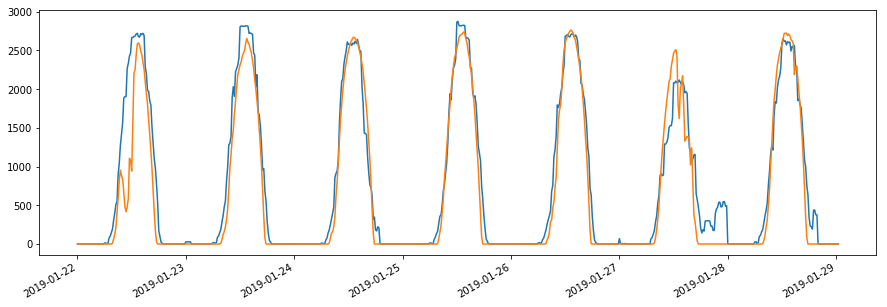

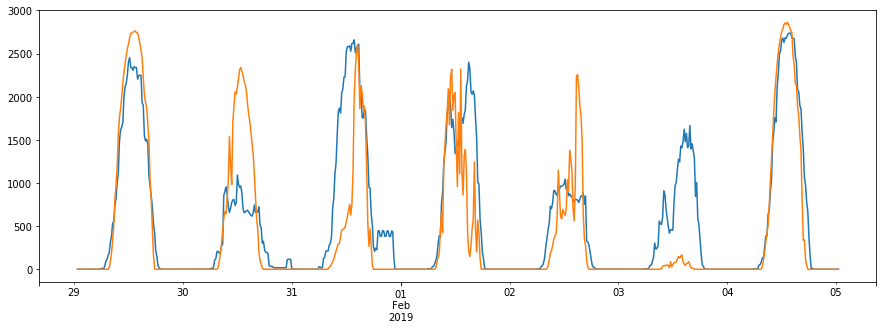

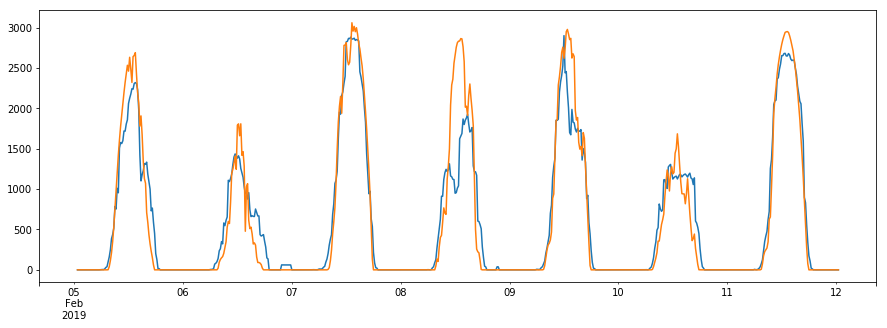

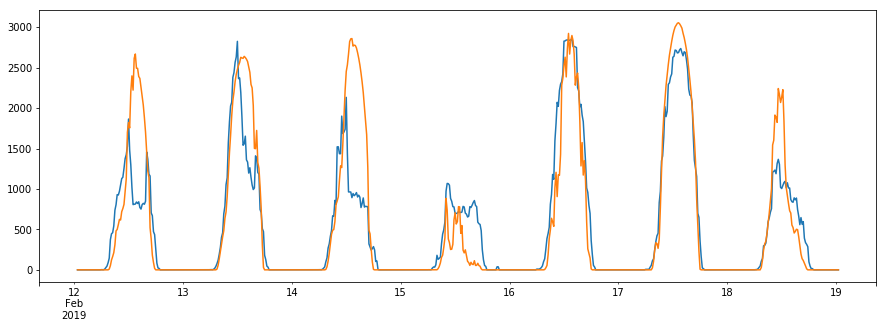

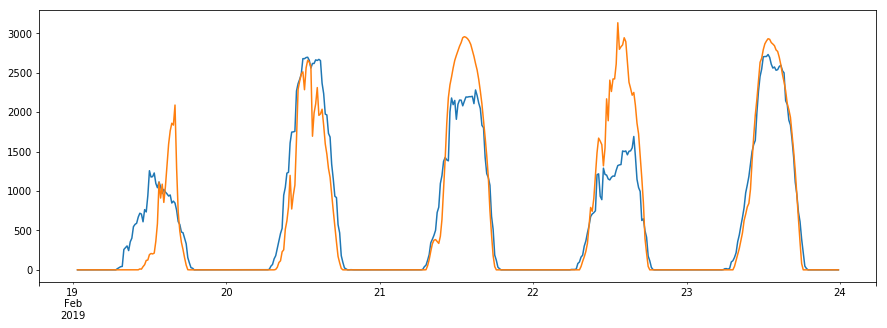

In [158]:
# rf
tester(days=7)